---
title: "🗓️ Week 09: Anomaly detection"
subtitle: "Theme: Unsupervised Learning"
author: "Dr. Ghita Berrada"
format: 
  html:
    from: markdown+emoji
    page-layout: full
    toc: true
    toc-depth: 2
self-contained: true
jupyter: python3
engine: jupyter
---

Welcome to Week 09! This week, we finish our exploration of unsupervised learning techniques with anomaly detection...

# ⚙️ Setup

Before you can load the libraries below, you might have to do the following package installs (feel free to skip if you already have done the installs before)

``` python
pip install -U kneed
pip install -U gower
```

Then, let's load the libraries we'll need today.

In [37]:
# libraries for dataframe and data manipulation
import pandas as pd
import numpy as np
import random
# libraries for data explaration
import missingno as msno
import sweetviz as sv
# libraries for data pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
# library to chain the steps of a modeling pipeline
from sklearn.pipeline import Pipeline
# libraries for dimensionality reduction
import umap
#libraries for clustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from gower import gower_matrix
#libraries for anomaly detection
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
#libraries for clustering/anomaly detection parameters selection
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
# libraries for plotting
from lets_plot import *
LetsPlot.setup_html()
from lets_plot.plot import gggrid
import matplotlib.pyplot as plt
import seaborn as sns
#libraries for table formatting
from pytablewriter import MarkdownTableWriter 

## Let's start with DBSCAN first!

Last week, we stopped by saying that k-means (and its variants) were not algorithms that were suitable for use in all (clustering) situations.

Let's see why again: let's check the pimpled smiley face example [here](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/). Does K-Means capture the expected clusters?

Now let's check the same example with [DBSCAN](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/).

#### How does DBSCAN work?

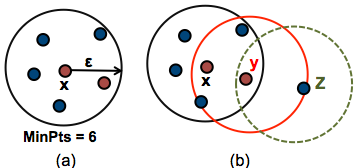

Fig 1: Different types of points and parameters in DBSCAN

*A few definitions to start with*

-   Any point $x$ in the data set, with a neighbour count greater than or equal to `MinPts`, is a **core point**
-   $x$ is a **border point**, if the number of its neighbors is less than `MinPts`, but it belongs to the $\epsilon$-neighborhood of some core point $z$.
-   If a point is neither a core nor a border point, then it is called a **noise point** or an **outlier**.

E.g: The figure (Fig. 1) shows the different types of points (core, border and outlier points) using `MinPts = 6`:

-   $x$ is a core point because $neighbours_\epsilon(x)=6$

-   $y$ is a border point because $neighbours_\epsilon(y)<MinPts$, but it belongs to the $\epsilon$-neighborhood of the core point $x$.

-   Finally, $z$ is a noise point.

*A few more definitions:*

-   **Direct density reachable**: A point “A” is directly density reachable from another point “B” if: i) “A” is in the $\epsilon$-neighborhood of “B” and ii) “B” is a core point. E.g $y$ is directly density reachable
-   **Density reachable**: A point “A” is density reachable from “B” if there are a set of core points leading from “B” to “A.
-   **Density connected**: Two points “A” and “B” are density connected if there are a core point “C”, such that both “A” and “B” are density reachable from “C”.

In density-based clustering, a cluster is defined as a group of density connected points.

### The DBSCAN Algorithm

1.  For each point $x_i$, compute the distance between $x_i$ and the other points. Find all neighbor points within distance `eps` of the starting point ($x_i$). Each point, with a neighbor count greater than or equal to `MinPts`, is marked as core point or visited.

2.  For each core point, if it’s not already assigned to a cluster, create a new cluster. Find recursively all its density connected points and assign them to the same cluster as the core point.

3.  Iterate through the remaining unvisited points in the data set.

The points that do not belong to any cluster are treated as outliers or noise.

If this explanation confuses you, you can have a look at [this Youtube video](https://www.youtube.com/watch?app=desktop&v=RDZUdRSDOok)

### How would we apply DBSCAN to the P/E ratio-Market Cap example?

We first re-create the stocks dataset from last week:

In [39]:
df = pd.read_csv("../data/stocks_data.csv")
numerical_columns = ['P/E Ratio', 'Market Cap', 'Dividend Yield', 'Debt-to-Equity']

# Categorical columns (e.g., Sector, Industry)
categorical_columns = ['Sector', 'Industry', 'Country']

def bagged_tree_imputation(df, numerical_columns, categorical_columns):
    # Step 1: Create a copy of the original dataframe
    df_original = df.copy()
    
    # Step 2: Handle categorical columns for the imputation model only
    df_encoded = df.copy()
    le_dict = {}
    
    for col in categorical_columns:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        le_dict[col] = le  # Store the encoder for reference if needed
    
    # Step 3: Use IterativeImputer with RandomForestRegressor
    imputer = IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=10), 
        max_iter=10, 
        random_state=42, 
        min_value=0
    )
    
    # Step 4: Impute only the numerical values
    df_original[numerical_columns] = imputer.fit_transform(df_encoded[numerical_columns + categorical_columns])[:, :len(numerical_columns)]
    
    return df_original


# Perform bagged tree imputation
df_imputed = bagged_tree_imputation(df, numerical_columns, categorical_columns)

# log transform then scale columns that are highly skewed (i.e all numerical columns)
scaler = StandardScaler()
for col in ['P/E Ratio', 'Market Cap', 'Dividend Yield', 'Debt-to-Equity']:
    df_imputed[f'{col} (log)'] = np.log1p(df_imputed[col])
df_imputed[['P/E Ratio (log norm)', 'Market Cap (log norm)', 'Dividend Yield (log norm)', 'Debt-to-Equity (log norm)']] = scaler.fit_transform(
    df_imputed[[col + ' (log)' for col in ['P/E Ratio', 'Market Cap', 'Dividend Yield', 'Debt-to-Equity']]])

And apply DBSCAN on it with manually selected parameters:

In [40]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
df_imputed['DBSCAN Cluster'] = dbscan.fit_predict(df_imputed[['P/E Ratio (log norm)', 'Market Cap (log norm)']])

# DBSCAN Plot
dbscan_plot = (
    ggplot(df_imputed, aes(x="P/E Ratio (log norm)", y="Market Cap (log norm)", color="DBSCAN Cluster"))
    + geom_point(size=5, alpha=0.7,tooltips=layer_tooltips()
            .line("Name: @Name")
            .line("Sector: @Sector")
            .line("Industry: @Industry")
            .line("Country: @Country"))
    + scale_color_discrete()
    + ggtitle("DBSCAN Clustering: P/E Ratio vs Market Cap\n (Variables first log transformed\n then standardised)")
    + xlab("P/E Ratio (log normalized)")
    + ylab("Market Cap (Log normalized)")
    + theme_minimal()
    +ggsize(1200,1200)
)

dbscan_plot.show()

What do you make of this?

As a comparison, our last clustering with k-means on this dataset after choosing an optimal $k$ of 6 produced:

In [41]:
kmeans = KMeans(n_clusters=6, random_state=42)
df_imputed['KMeans Cluster'] = kmeans.fit_predict(df_imputed[['P/E Ratio (log norm)', 'Market Cap (log norm)']])
kmeans_plot = (
    ggplot(df_imputed, aes(x="P/E Ratio (log norm)", y="Market Cap (log norm)", color="KMeans Cluster"))
    + geom_point(size=5, alpha=0.7,tooltips=layer_tooltips()
            .line("Name: @Name")
            .line("Sector: @Sector")
            .line("Industry: @Industry")
            .line("Country: @Country"))
    + scale_color_discrete()
    + ggtitle("K-Means Clustering: P/E Ratio vs Market Cap\n (Log transformed then standardized)")
    + xlab("P/E Ratio (log normalized)")
    + ylab("Market Cap (Log normalized)")
    + theme_minimal()
    +ggsize(1200,1200)
)

gggrid([kmeans_plot,dbscan_plot],ncol=1)

### How do we choose the `eps` parameter in DBSCAN

Now that we now how DBSCAN works, the million dollar question is how do we set its parameters? Well, once again, it's rather tricky...

The value of `minPts` should be at least one greater than the number of dimensions of the dataset, i.e., **`minPts>=Dimensions+1`**. It does not make sense to take `minPts` as 1 because the result will be each point being a separate cluster. Therefore, it must be at least 3. Generally, we go for at least twice the dimensions, e.g if we only only select two variables in our data (i.e `depth` and `mag` ), we'd select `minPts` as 4.

Now that `minPts` is set, we can select `eps` using the k-distance graph. In practice, this means that:

-   you compute the average distance (by default Euclidean distance) between each point and its k nearest neighbors, where k = the `minPts` value you selected.

-   the average k-distances are then plotted in ascending order on a k-distance graph. You’ll find the optimal value for `eps` at the point of maximum curvature (i.e. where the graph has the greatest slope).

    The code below gives an example of the k-distance graph for our ongoing stock clustering example...

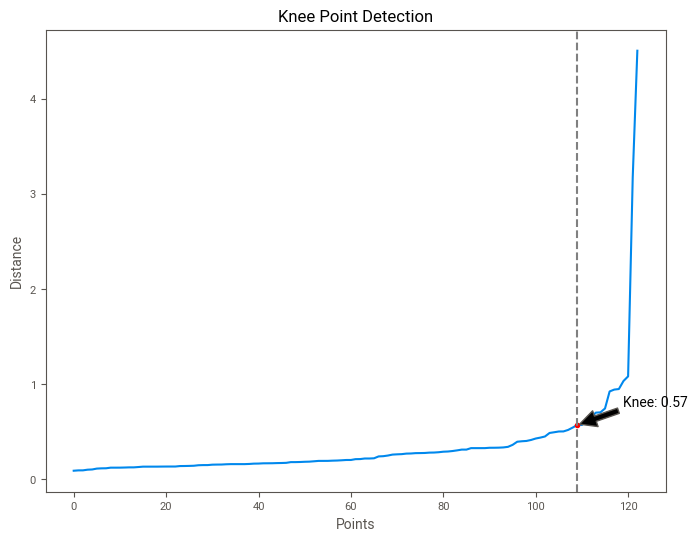

The value of the knee is: 0.5721967826682


In [42]:
nearest_neighbors = NearestNeighbors(n_neighbors=4)
neighbors = nearest_neighbors.fit(df_imputed[['P/E Ratio (log norm)', 'Market Cap (log norm)']])
distances, indices = neighbors.kneighbors(df_imputed[['P/E Ratio (log norm)', 'Market Cap (log norm)']])
distances = np.sort(distances[:, 3], axis=0)

# Find the knee using KneeLocator
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

# Create the plot
fig = plt.figure(figsize=(8, 6))
plt.plot(i, distances)
plt.xlabel("Points")
plt.ylabel("Distance")
plt.title("Knee Point Detection")

# Get knee coordinates
knee_index = knee.knee
knee_value = distances[knee_index]

# Add knee point marker
plt.plot(knee_index, knee_value, 'ro')

# Add annotation with arrow
plt.annotate(f"Knee: {knee_value:.2f}",
             xy=(knee_index, knee_value),
             xytext=(knee_index + 10, knee_value + 0.2),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Add vertical line at knee
plt.axvline(x=knee_index, color='gray', linestyle='--')

# Display the plot
plt.show()

# Print the knee value
print(f"The value of the knee is: {knee_value}")

As we can see, the point of maximum curvature is around 0.52, which sets our `eps` value...

Let's see if it changes our clustering:

In [43]:
dbscan2 = DBSCAN(eps=0.52, min_samples=4)
df_imputed['DBSCAN Cluster2'] = dbscan2.fit_predict(df_imputed[['P/E Ratio (log norm)', 'Market Cap (log norm)']])

# DBSCAN Plot
dbscan_plot2 = (
    ggplot(df_imputed, aes(x="P/E Ratio (log norm)", y="Market Cap (log norm)", color="DBSCAN Cluster2"))
    + geom_point(size=5, alpha=0.7,tooltips=layer_tooltips()
            .line("Name: @Name")
            .line("Sector: @Sector")
            .line("Industry: @Industry")
            .line("Country: @Country"))
    + scale_color_discrete()
    + ggtitle("DBSCAN Clustering: P/E Ratio vs Market Cap \n(variables log transformed then standardized))")
    + xlab("P/E Ratio (log normalized)")
    + ylab("Market Cap (Log normalized)")
    + theme_minimal()
)

dbscan_plot2.show()

In [44]:
gggrid([dbscan_plot,dbscan_plot2],ncol=1)

What should we make of this?

- Cluster 0 (Red): This cluster represents a group of data points with relatively low P/E ratios and moderate Market Caps. These might be undervalued companies or companies with lower growth potential (Apple, Microsoft, Tencent, NVidia or Alphabet are in this cluster!).
- Cluster -1 (Blue): This cluster represents data points that are considered noise by the DBSCAN algorithm. They don't belong to any dense region and are likely outliers. Notice how they are scattered far from the main groups (Samsung, Ericsson but also Tesla and Nintendo are in this group).
- Cluster 1 (Green): This cluster represents a group of data points with a wide range of P/E ratios but generally lower Market Caps. This could be a diverse group of companies, perhaps including smaller or newer companies (Alibaba is in this cluster but so is PepsiCo or Procter & Gamble).
- Cluster 2 (Purple) : It appears to represent data points that are somewhat intermediate in both P/E Ratio and Market Cap. They are located between the red and green clusters, suggesting a separate group with distinct characteristics. They are also relatively close to the noise points, but dense enough to be considered a cluster.

If this data were used for investment analysis, the clusters could suggest different investment strategies. For example, Cluster 0 might represent value stocks, while Cluster 1 might represent a mix of growth and smaller-cap stocks.

|Method|	Advantages|	Disadvantages|
|------|-------------|---------------|
|K-Means|	Works well with well-separated clusters|	Struggles with non-spherical clusters & noise|
|DBSCAN|	Finds arbitrarily shaped clusters, detects outliers|	Requires tuning `eps`, struggles with varying densities|

### What if we have more than 2 features (especially a mix of categorical and numerical features)? 

By default, DBSCAN (just like $k$-means) makes use of the Euclidean distance to do the clustering. But, unlike $k$-means, it can work with other metrics too. 

This is really handy if you have a mix of numerical and categorical features. 

One metric that is suited for a mix of numeric and categorical features is the Gower distance: this is a metric that combines different distance metrics for each attribute type (i.e numeric or categorical) and calculates the overall distance between two points as an average of individual attribute distances.

More specifically, the Gower distance is computed as follows:
  
- for a numerical feature: $$\textrm{distance}_{i,j}^k=\frac{|x_i^k-x_j^j|}{R_k}$$ where $x_i^k$ and $x_j^k$ are the numerical values of feature $k$ for observations $i$ and $j$ respectively and $R_k$ is the range of feature $k$ (i.e the difference between its maximum and minimum values).
- for a categorical feature: $$\textrm{distance}_{i,j}^k=\begin{cases} 
0 \quad \textrm{if }x_i^k = x_j^k \\ 
1 \quad \textrm{if }x_i^k \neq x_j^k 
\end{cases}$$ where $x_i^k$ and $x_j^k$ are the categorical values of feature $k$ for observations $i$ and $j$ respectively
-  the overall distance is then computed as: $$D(i,j)=\frac{1}{p}\sum_{k=1}^p \textrm{distance}_{i,j}^k$$ where $p$ is the number of features

*Quick example*

|Subject ID|	Age|	Handedness|	Eye Colour|	Knows Python|
|-------|----------|--------------|------------|---------------|
|001|	28|	Right|	Blue|	Yes|
|002|	34|	Left|	Blue|	No|
|003|	22|	Right|	Green|	Yes|
|004|	45|	Right|	Hazel|	No|
|005|	30|	Left|	Brown|	Yes|

Let's try and compute the distance between observations with `Subject ID` 001 and 002:

- `Age` is numerical and has a range 45-22=23 so $s_{Age}=\frac{28-34}{23}=0.26$
- `Handedness`, `Eye`, `Colour` and `Knows Python` are all categorical and 
    
    - $s_{Handedness}=1$
    - $s_{Colour}=0$
    - $s_{Knows Python}=1$
- Finally the Gower distance is: $d(001,002)=\frac{1}{5}\times(0.26+2)=0.452$

When applying the Gower distance, we don't need to scale numerical features, nor do we need to encode categorical features:

- The Gower distance algorithm automatically normalizes numerical variables internally. It calculates the range (max - min) for each numerical feature and uses that to scale distances.
- The Gower distance handles categorical variables directly by using a simple matching coefficient. It computes a 0 if two values are identical and a 1 if they're different, without requiring any encoding

This is exactly why the Gower distance is so useful for mixed data types - it handles all the necessary transformations internally, saving us preprocessing steps and ensuring that both categorical and numerical features contribute appropriately to the overall distance calculation.

In [51]:
numerical_cols = ['P/E Ratio', 'Market Cap', 'Dividend Yield', 'Debt-to-Equity']
categorical_cols = ['Sector', 'Industry', 'Country']
interpretation_variables = ["Ticker", "Sector", "Industry","Country","Name"]
# Combine numerical and categorical columns
df_combined = df_imputed[numerical_cols + categorical_cols +interpretation_variables]

# Compute Gower distance matrix
gower_dist_matrix = gower_matrix(df_combined[numerical_cols + categorical_cols])

#### Determining DBSCAN's hyperparameters

We have 7 features here so $k$ should be at least equal to 2*7=14. let's set it to 14. let's now set `eps`

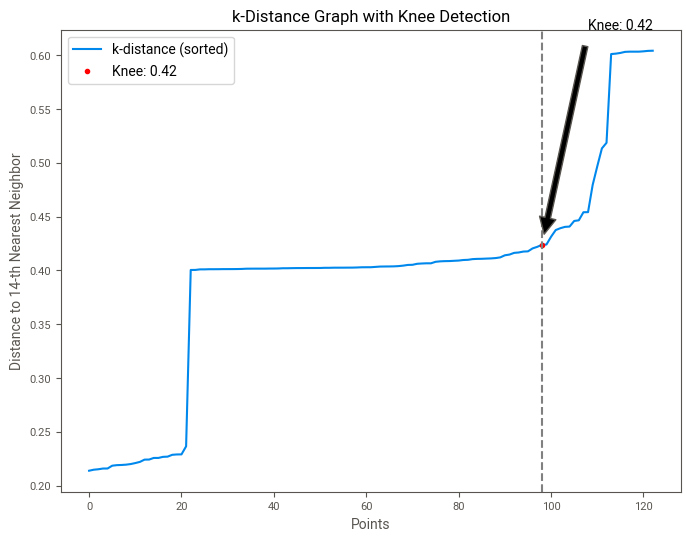

The value of the knee is: 0.42379721999168396


In [56]:
k = 14  # Adjusting k to reflect the number of features (2 * 7 = 14)
neighbors = NearestNeighbors(n_neighbors=k, metric="precomputed")  # k=14
neighbors.fit(gower_dist_matrix)
distances, indices = neighbors.kneighbors()

# Sort the distances for each point to visualize the k-distance
sorted_distances = np.sort(distances[:, -1])  # Take the distance of the 14th nearest neighbor

# Use KneeLocator to find the knee point in the k-distance graph
i = np.arange(len(sorted_distances))
knee_locator = KneeLocator(i, sorted_distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(i, sorted_distances, label='k-distance (sorted)')

# Get knee coordinates
knee_index = knee_locator.knee
knee_value = sorted_distances[knee_index]

# Add knee point marker
plt.plot(knee_index, knee_value, 'ro', label=f'Knee: {knee_value:.2f}')

# Add annotation with arrow
plt.annotate(f"Knee: {knee_value:.2f}",
             xy=(knee_index, knee_value),
             xytext=(knee_index + 10, knee_value + 0.2),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Add vertical dashed line at knee
plt.axvline(x=knee_index, color='gray', linestyle='--')

# Add labels and title
plt.xlabel('Points')
plt.ylabel(f'Distance to {k}-th Nearest Neighbor')
plt.title('k-Distance Graph with Knee Detection')
plt.legend()
plt.show()

# Print the knee value
print(f"The value of the knee is: {knee_value}")

### DBSCAN clustering and visualisation of results with UMAP

In [57]:
# We use the previously determined eps value (e.g., based on the k-distance graph's elbow)
eps_value = knee_value  # Replace with value selected from k-distance plot
min_samples = 14  

# Apply DBSCAN with Gower distance matrix and the selected eps
dbscan = DBSCAN(metric="precomputed", eps=eps_value, min_samples=min_samples)
labels = dbscan.fit_predict(gower_dist_matrix)

# Add the cluster labels to the dataframe
df_combined.loc[:,'DBSCAN_Cluster'] = labels

Before we are able to visualise our results, we need to reduce the dimensionality (we have 7 features i.e 7 dimensions at present!).

Let's use UMAP for this. Before we are able to use UMAP, we need to encode the categorical features (UMAP does not handle non-numerical features): we'll one-hot encode them so as not to introduce artificial ordering through label-encoding.

In [59]:
# Remove duplicated columns
df_combined = df_combined.loc[:, ~df_combined.columns.duplicated()]

# Use one-hot encoding for categorical features (NOT label encoding)
encoder = OneHotEncoder(sparse_output=False)
categorical_encoded = encoder.fit_transform(df_combined[categorical_cols])
categorical_encoded_df = pd.DataFrame(
    categorical_encoded,
    columns=encoder.get_feature_names_out(categorical_cols),
    index=df_combined.index
)

# Combine with numerical features
umap_input = pd.concat([df_combined[numerical_cols].reset_index(drop=True), 
                       categorical_encoded_df.reset_index(drop=True)], axis=1)

# Apply UMAP
umap_model = umap.UMAP(n_components=2)
df_combined[['UMAP1', 'UMAP2']] = umap_model.fit_transform(umap_input)

# Create plot
umap_plot = (
    ggplot(df_combined, aes(x="UMAP1", y="UMAP2", color="DBSCAN_Cluster"))
    + geom_point(size=3, alpha=0.7, tooltips=layer_tooltips()
        .line("Name: @Name")
        .line("Sector: @Sector")
        .line("Industry: @Industry")
        .line("Country: @Country"))
    + scale_color_brewer(type='qual', palette="Set3")
    + ggtitle("DBSCAN clustering with Gower distance\n Visualisation in the UMAP space")
    + theme_minimal()
)

umap_plot.show()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Quick note: Similarity metrics

Underlying the discussion about clustering, are similarity metrics. We mostly assumed until now that the similarity metric that was used was the Euclidean distance (and for k-means, this is a fair assumption to make). But there are cases where the Euclidean distance would not be an appropriate choice (e.g when comparing strings or sets or for computer vision or recommendation engines applications).

Here is a quick run-through of some of the most common similarity metrics:

*Real-valued data:*

-   Euclidian distance: $d(A,B)=\sqrt{\sum_{i=1}^n |A_i-B_i|^2}$

-   Cosine distance: $S_C(A,B)=\frac{\sum_{i=1}^n A_iB_i}{\sqrt{\sum_{i=1}^n A_i^2}\sqrt{\sum_{i=1}^n B_i^2}}$

where **A** and **B** are two n-dimensional vectors of attributes, and $A_i$ and $B_i$ the $i$th components of vectors **A** and **B** respectively

(metric frequently used in NLP and computer vision - see [this page](https://www.datastax.com/guides/real-world-applications-of-cosine-similarity) for more information)

*String similarity:*

-   Hamming distance: given two strings of equal length, it is the number of positions at which the corresponding symbols (i.e either letters, bits, or decimal digits) are different e.g:

    -   [0000]{style="color:#BA160C"} and [1111]{style="color:#BA160C"} is 4
    -   ca[t]{style="color:#BA160C"} and ca[r]{style="color:#BA160C"} is 1
    -   c[a]{style="color:#BA160C"}l[l]{style="color:#BA160C"} and c[o]{style="color:#BA160C"}l[d]{style="color:#BA160C"} is 2

-   Levenstein distance: given two strings, it's the minimal number of edits (substitutions, deletions, insertions) needed to turn one string into another e.g:

    The Levenshtein distance between *kitten* and *sitting* is 3, since the following 3 edits change one into the other, and there is no way to do it with fewer than 3 edits:

    1.  [k]{style="color:#BA160C"}itten → [s]{style="color:#BA160C"}itten (substitution of "s" for "k"),
    2.  sitt[e]{style="color:#BA160C"}n → sitt[i]{style="color:#BA160C"}n (substitution of "i" for "e"),
    3.  sittin → sittin[g]{style="color:#BA160C"} (insertion of "g" at the end).

*Set similarity:*

A set is a collection of items with no order or repetition. Sets are typically used to represent relationships or associations between objects or even people.

-   Jaccard index: it is often used in recommendation systems and social media analysis and measures the similarity between two sets based on the number of items present in both sets relative to the total number of items:

    $J(A,B)=\frac{|A\cap B|}{|A\cup B|}$

    where A and B are two sets, $|A\cap B|$ the number of items included in both sets and $|A\cup B|$ the total number of items

Another useful resources: [this page](https://scikit-learn.org/stable/modules/clustering.html) compares various clustering algorithms (among which k-means and DBSCAN) and shows their parameters, use cases,...

## Part 2: Anomaly detection

### What are anomalies?

Anomalies are data points that deviate significantly from the expected or “normal behavior.”

We generally distinguish between univariate and multivariate outliers/anomalies:

-   **univariate outliers** exist in a single feature in isolation: they are extreme or abnormal values that deviate from the typical range of values for that specific feature. Say that the temperatures in London in December are typically between 2 and 7 degrees. A temperature of -10 degree in December would be considered a univariate outlier/anomaly.

-   **Multivariate outliers** are found by combining the values of multiple variables at the same time: taken separately, the values for each variable appear normal but in conjunction, they are not. Take, for example, a month of December in London where the temperatures are persistently on the higher end of the usual range (i.e close to 7 degrees) and where there were fewer than 5 days of rain: though the temperatures were in the normal range and it rained as usual, it is unusual for the temperatures to consistently stay on the higher end of the scale for such a long period and for it to rain for a short period, and therefore, taken cumulatively, the pattern for December is clearly an outlier!
  
### Running example for this part: The OECD Better Life Index Indicators

Let's introduce our main example for this part.

This dataset is a dataset sourced from [OECD](https://data-explorer.oecd.org/vis?tenant=archive&df[ds]=DisseminateArchiveDMZ&df[id]=DF_BLI&df[ag]=OECD&dq=...TOT&pd=%2C&to[TIME]=false&vw=tb&ly[cl]=INDICATOR&ly[rw]=LOCATION). The Better Life Index is designed to let people visualise and compare some of the key factors – like education, housing, environment, and so on – that contribute to well-being in OECD countries. The Index records 11 topics (housing, environment, work-life balance, education, income, jobs, safety, health, community, civic engagement, life satisfaction) further subdivided in more precise indicators (e.g Labour market insecurity in Jobs category or employees working very long hours in the work-life balance category). We take the latest data available for the index.

In [14]:
df_oecd = pd.read_csv("../data/oecd_better_life_index_data.csv")

Let's have a look at the mssingness patterns:

<Axes: >

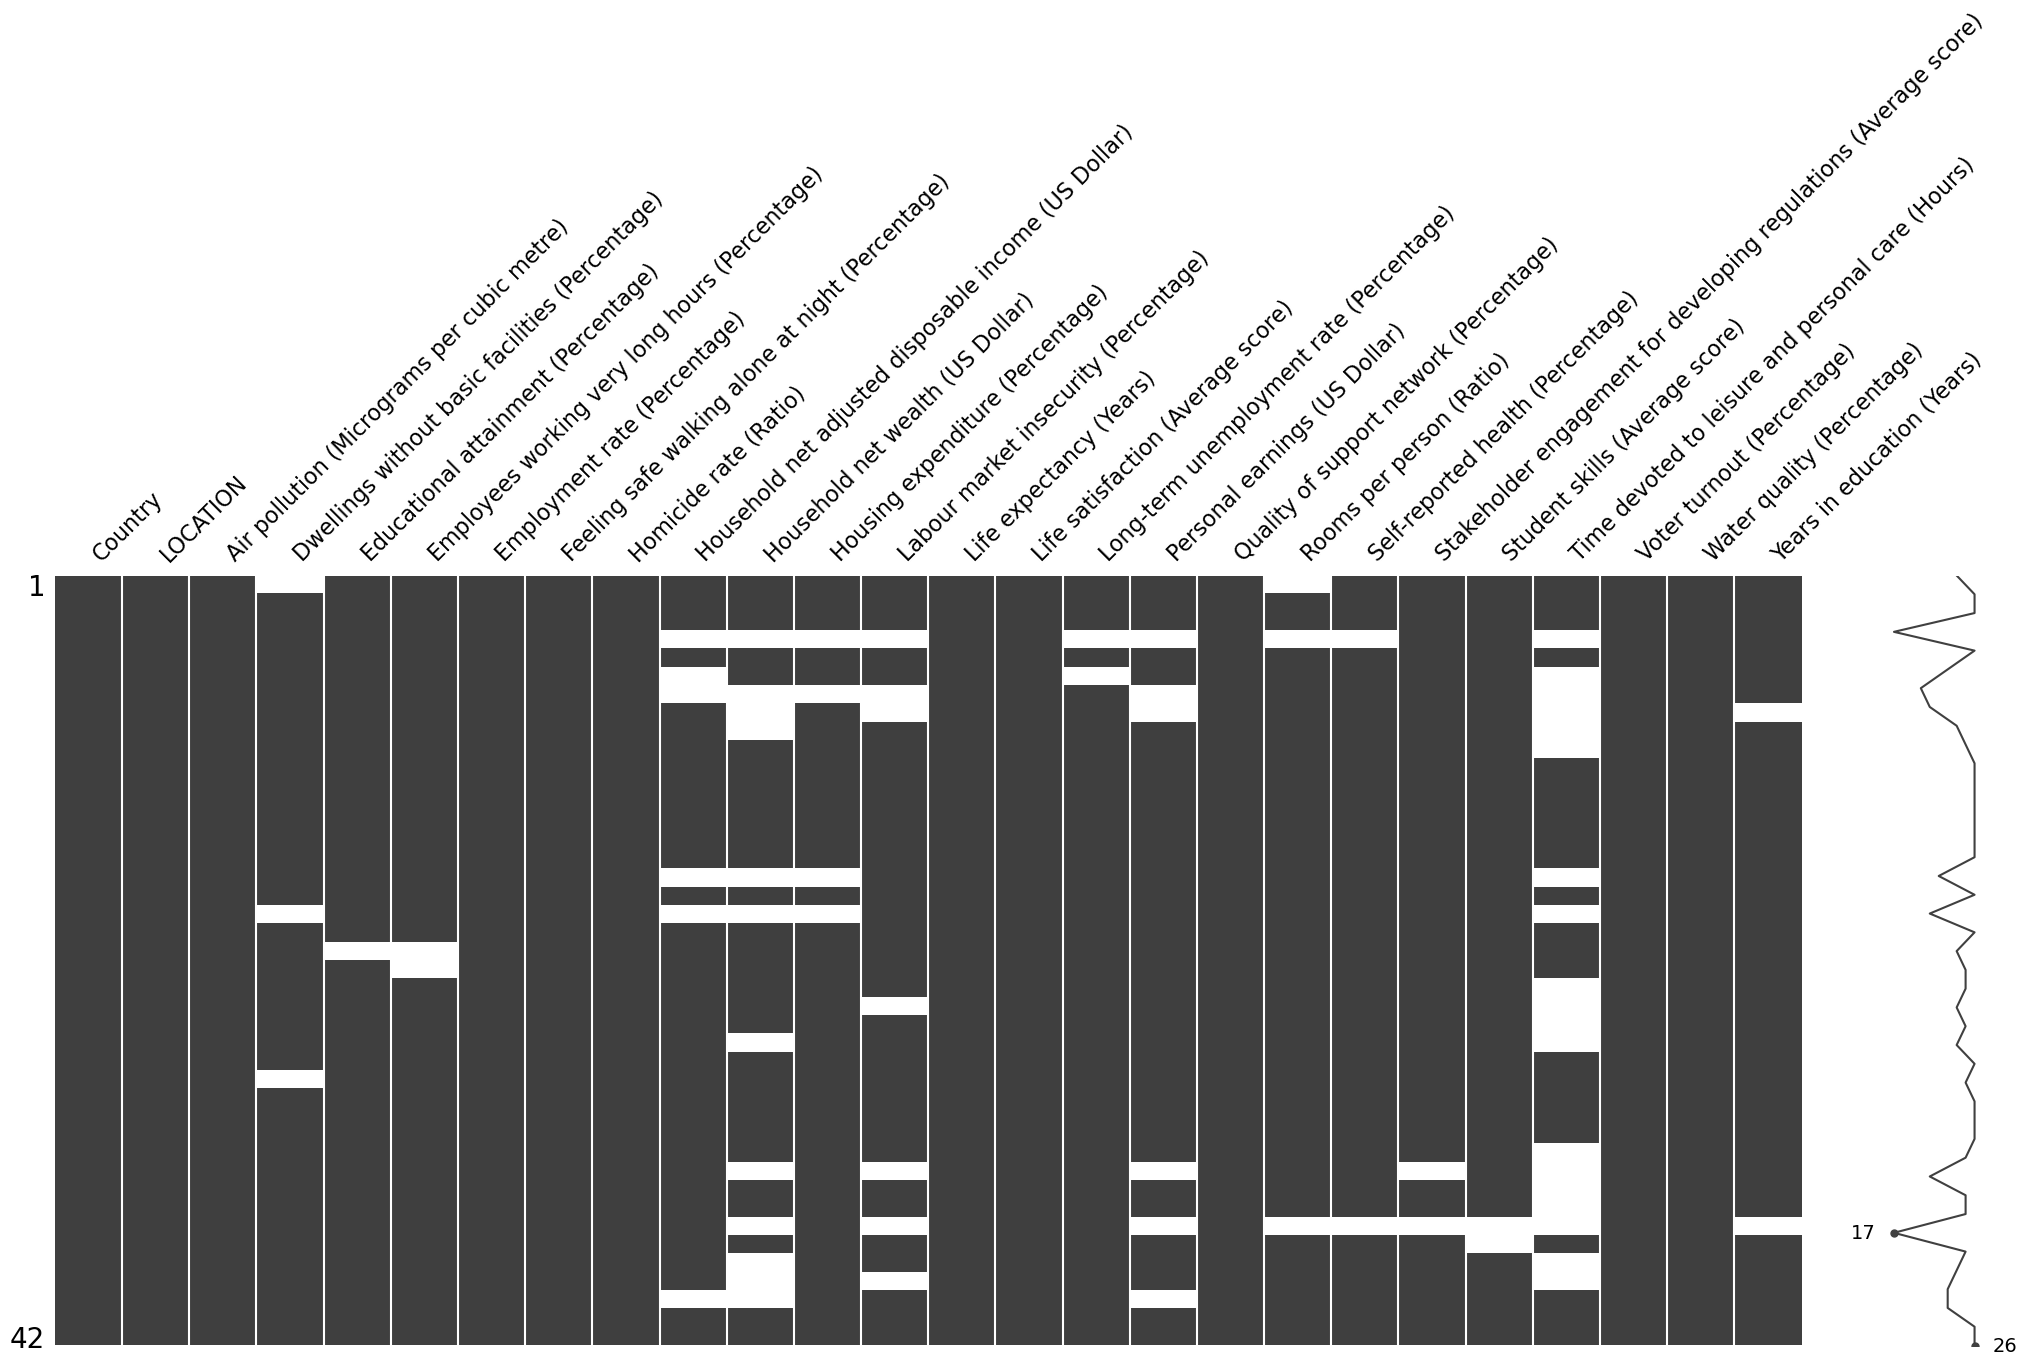

In [15]:
msno.matrix(df_oecd)

                                             |          | [  0%]   00:00 -> (? left)


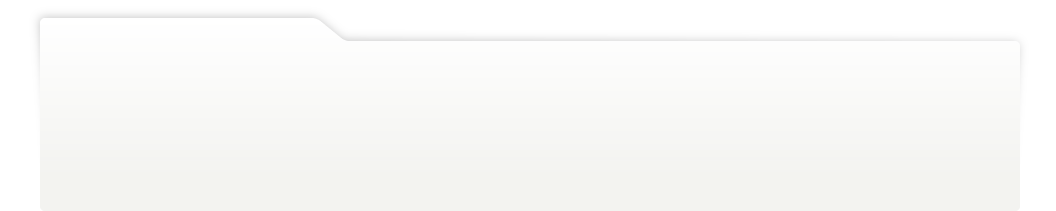
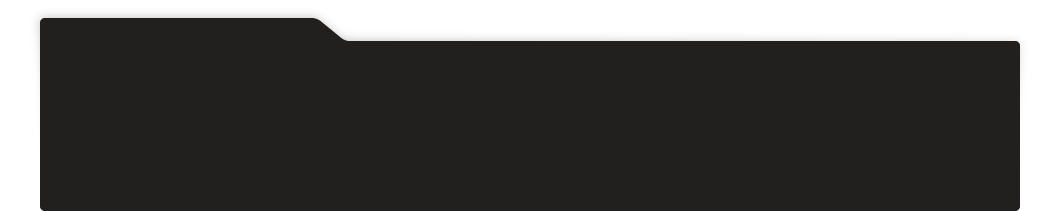
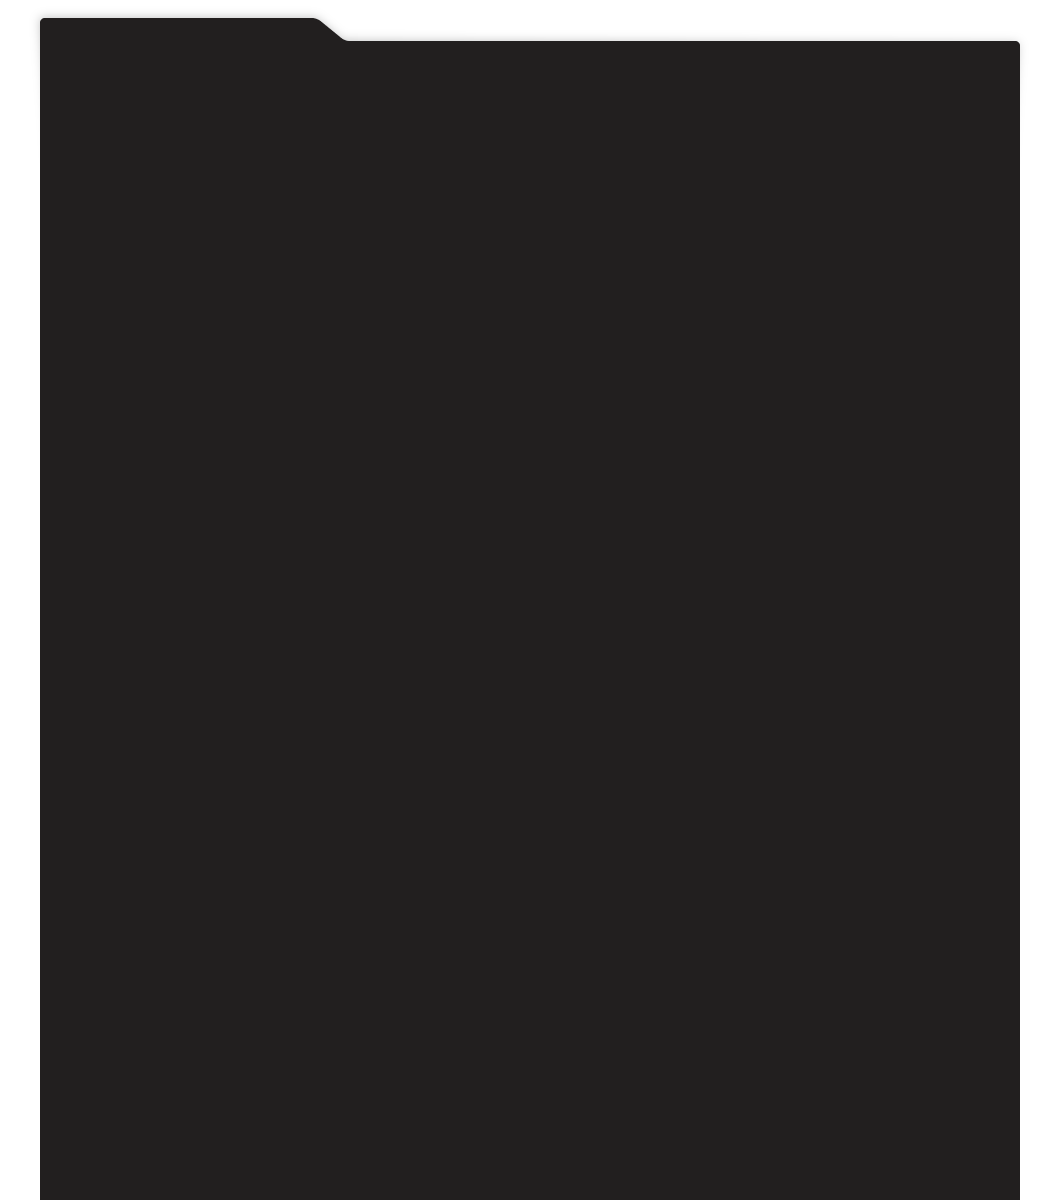
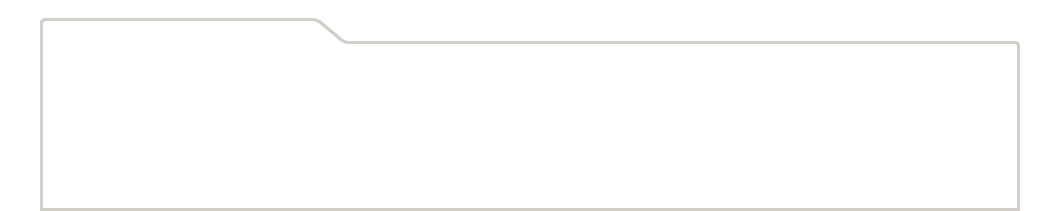
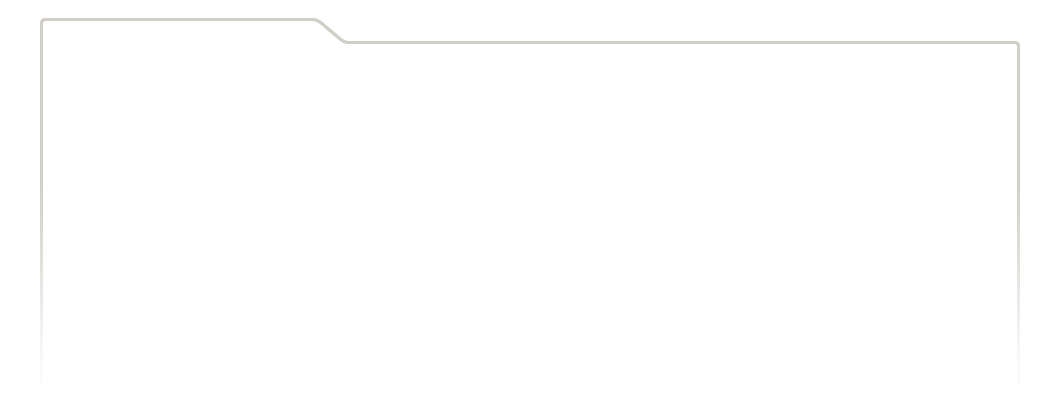
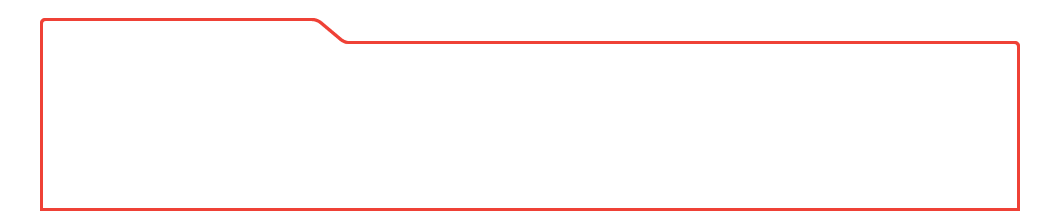
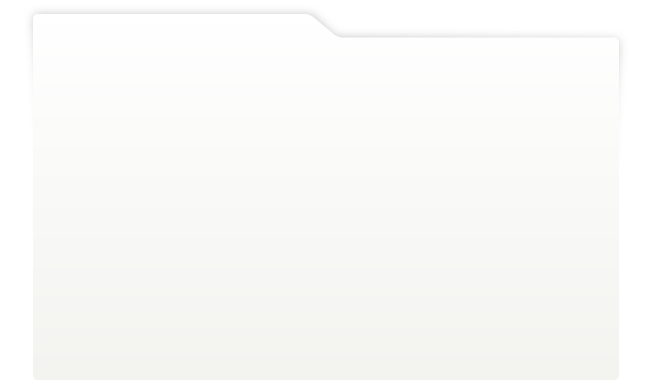
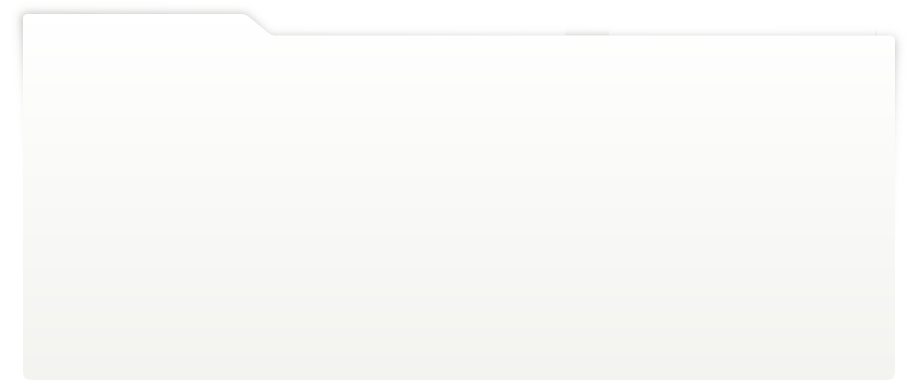
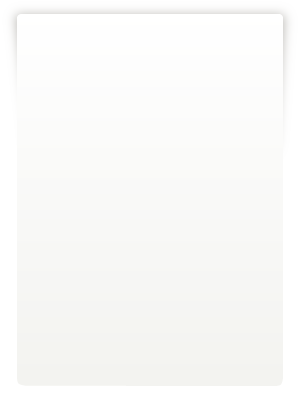
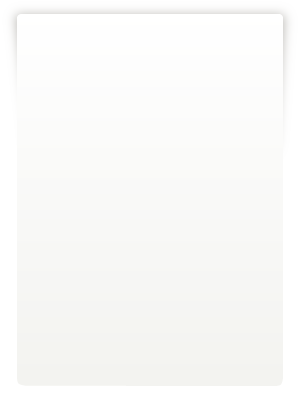
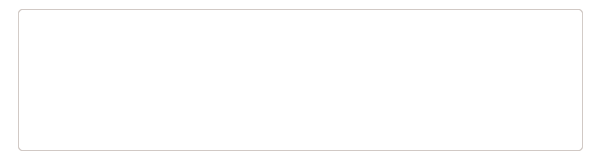
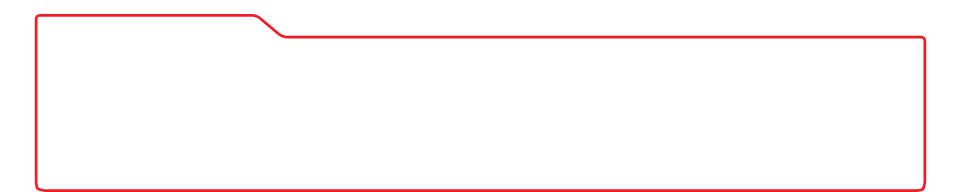
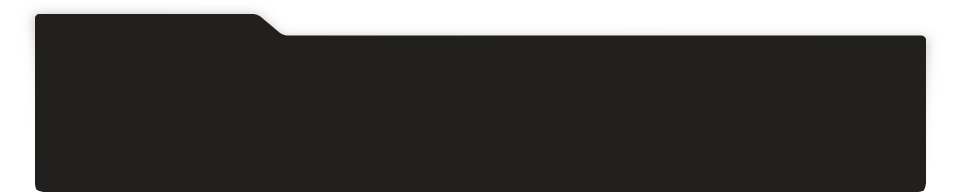
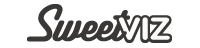
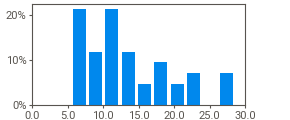
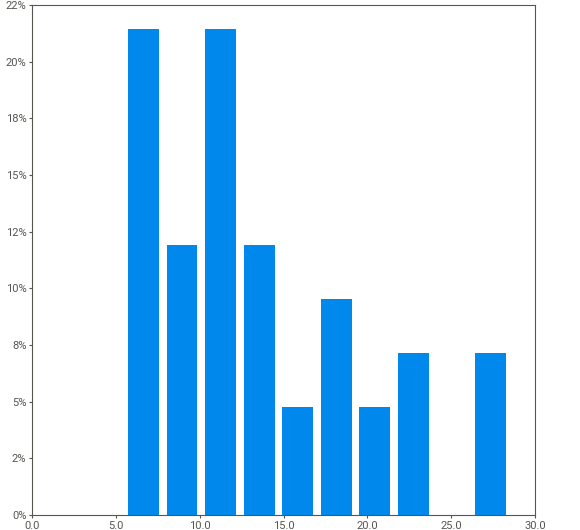
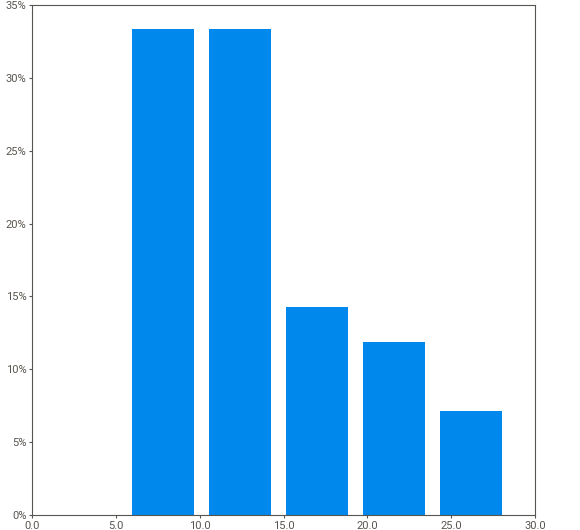
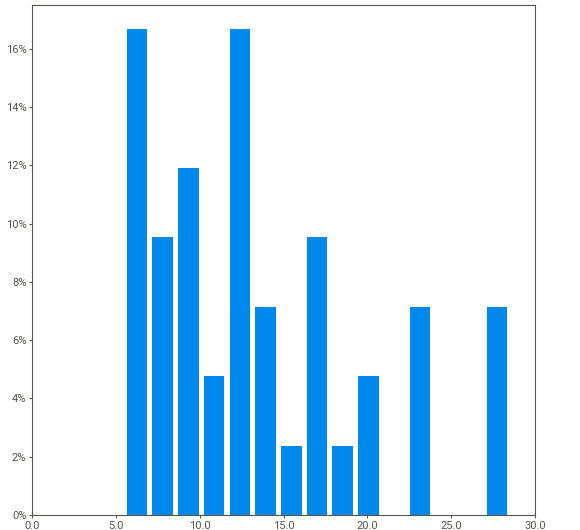
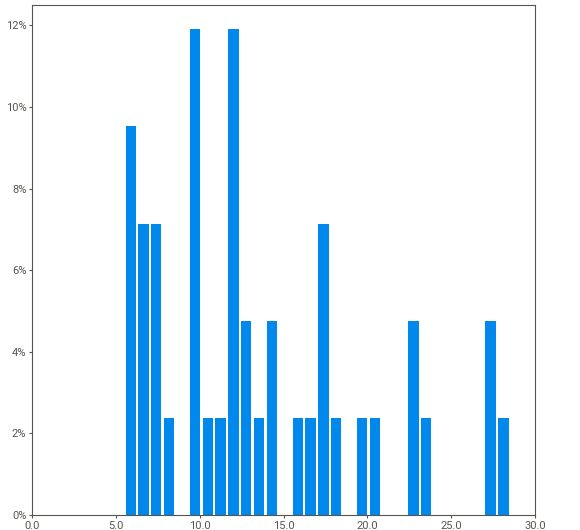
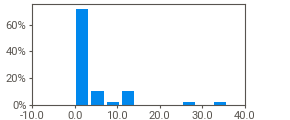
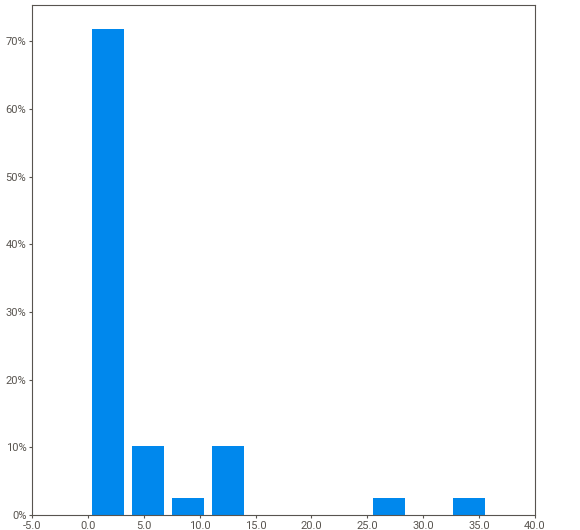
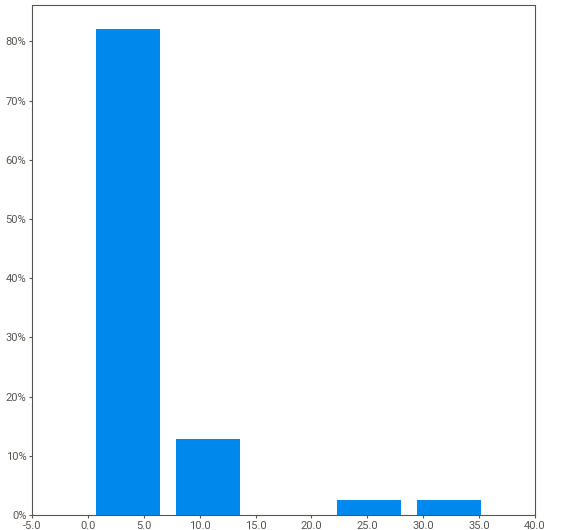
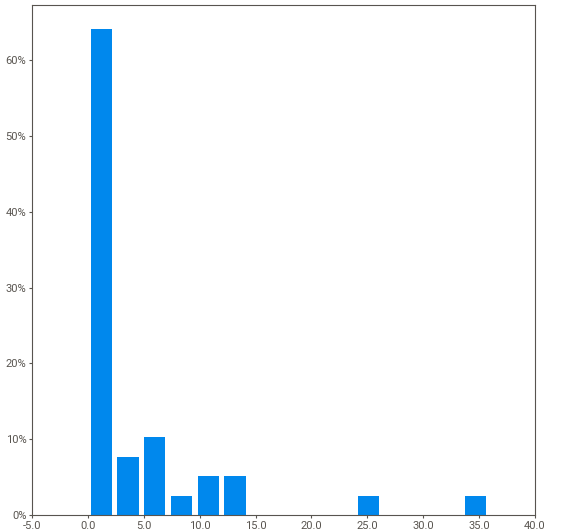
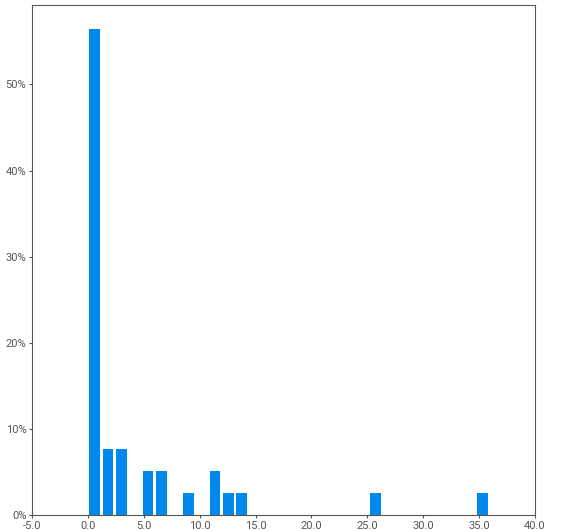
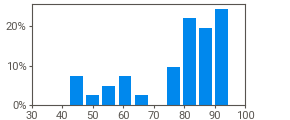
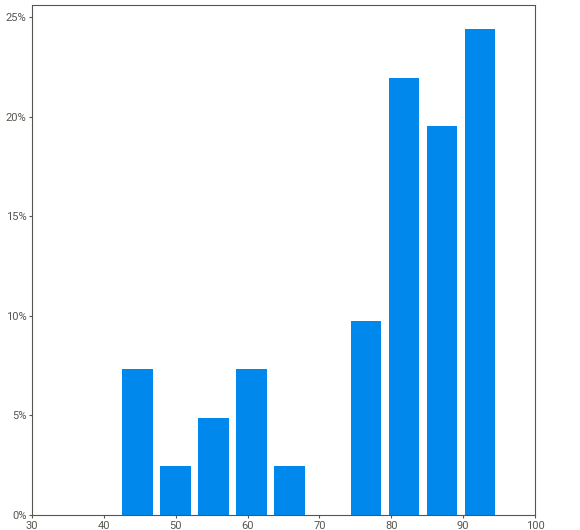
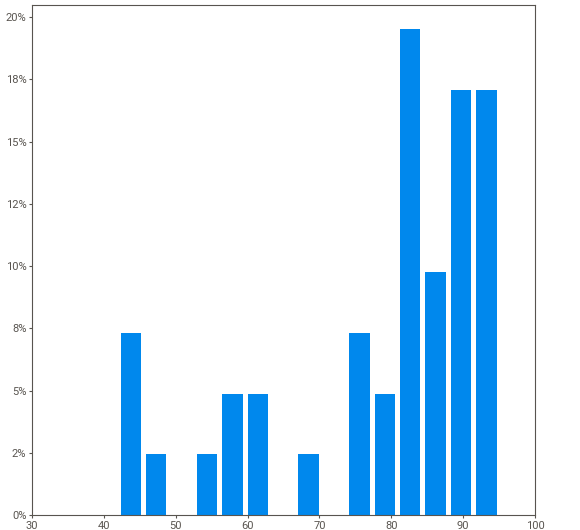
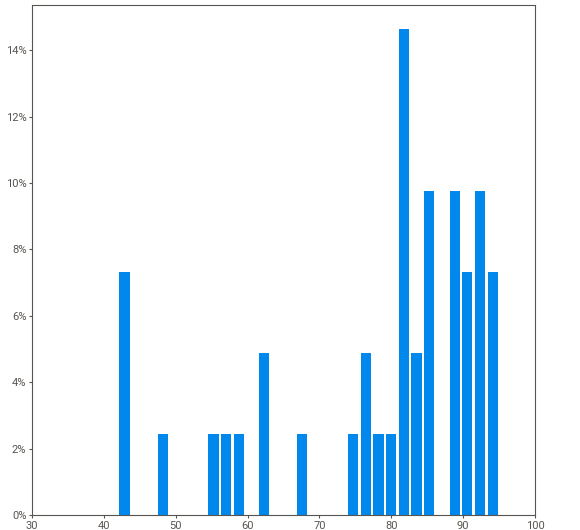
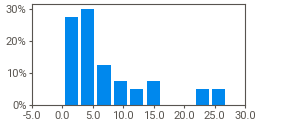
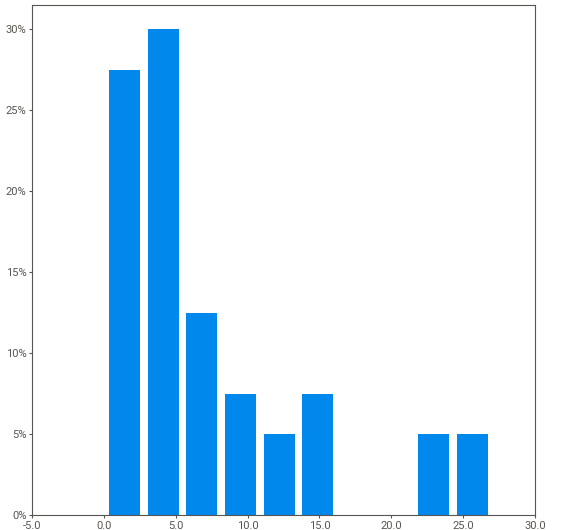
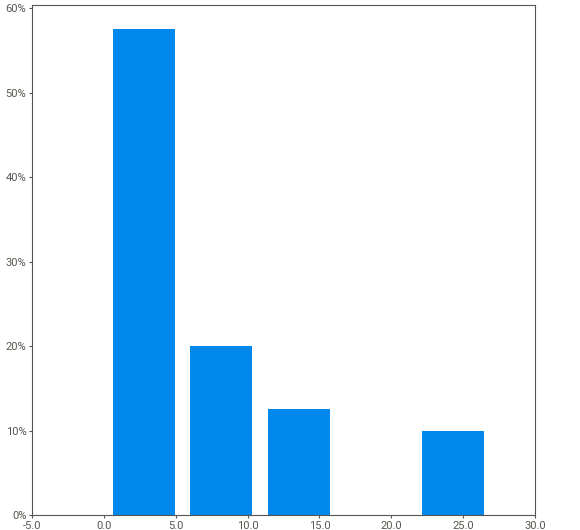
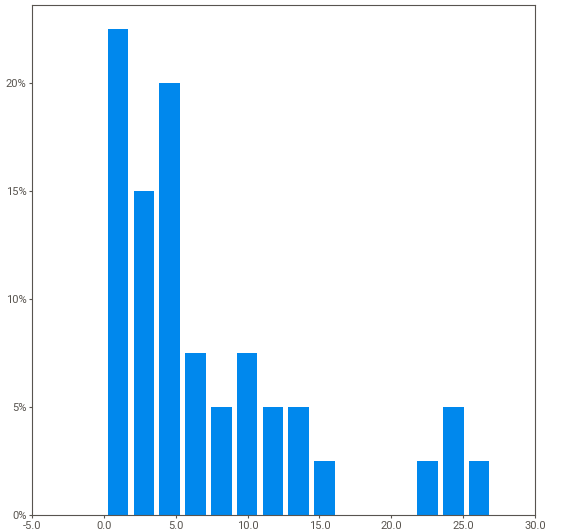
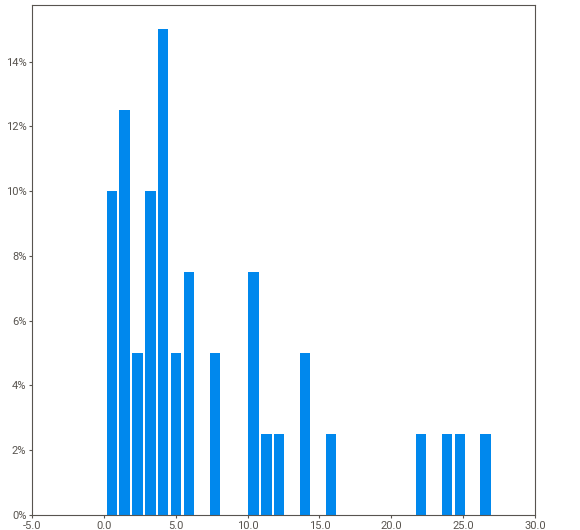
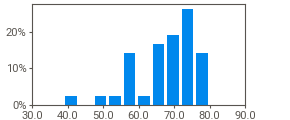
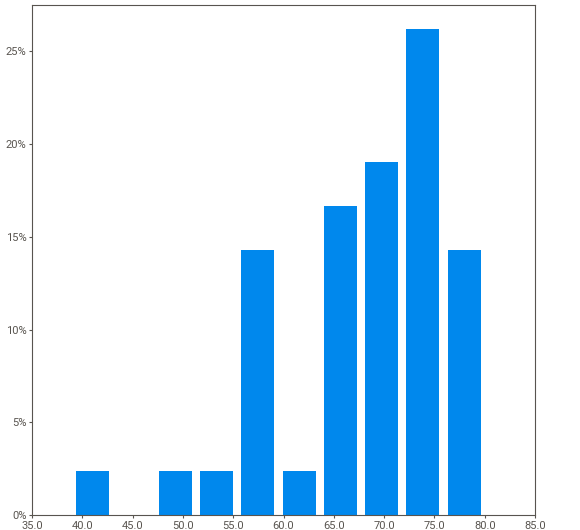
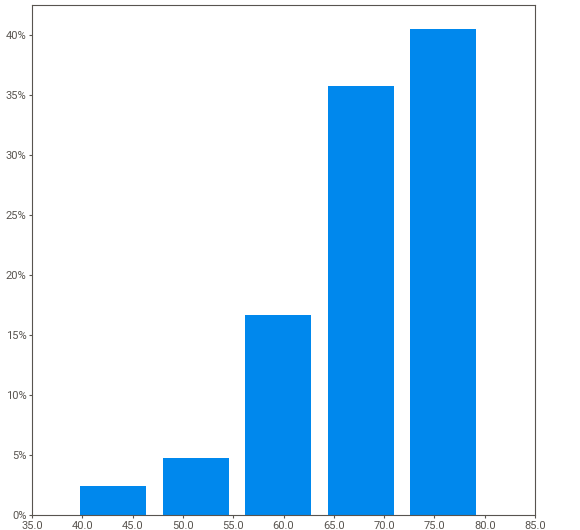
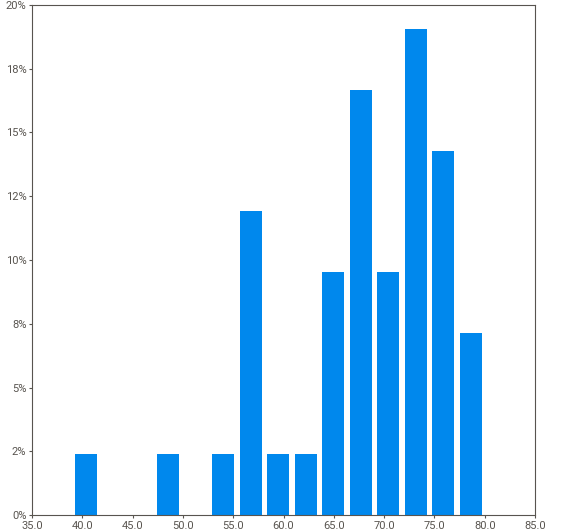
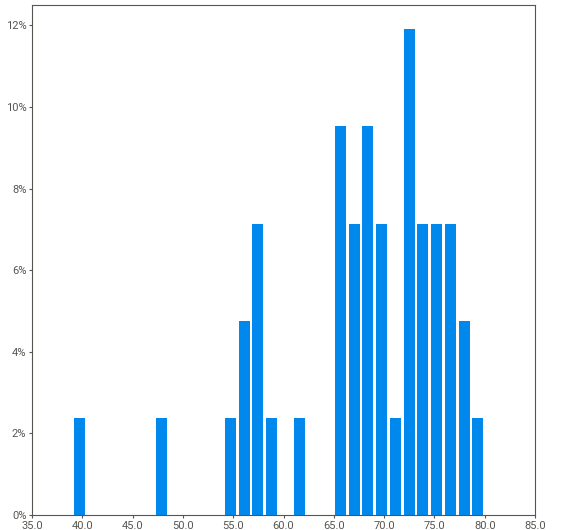
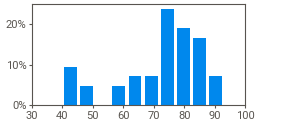
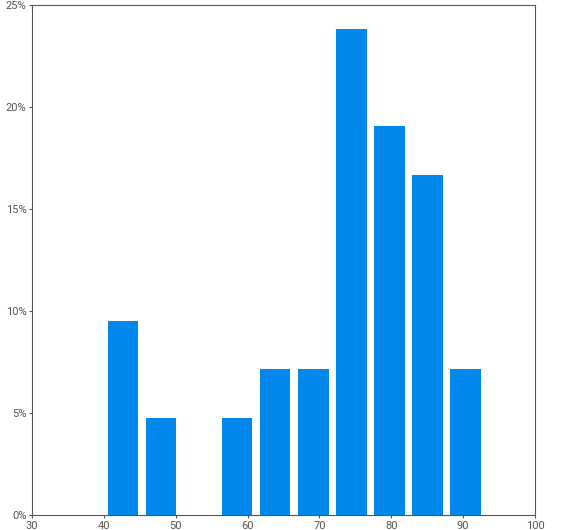
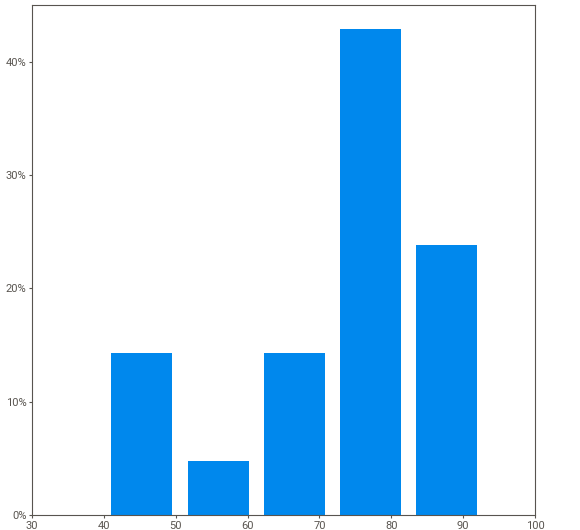
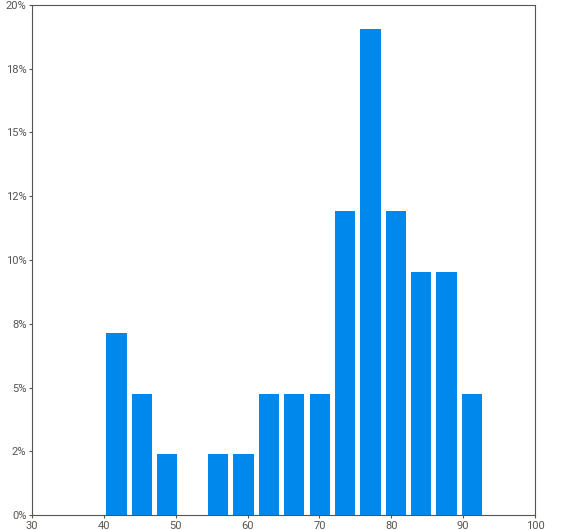
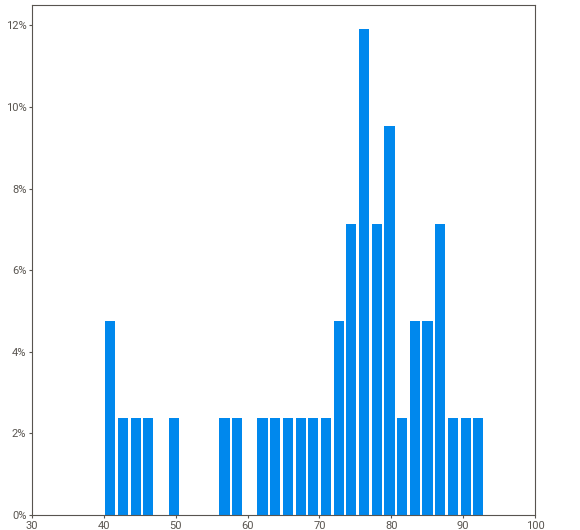
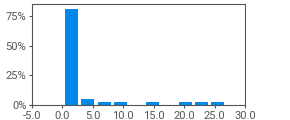
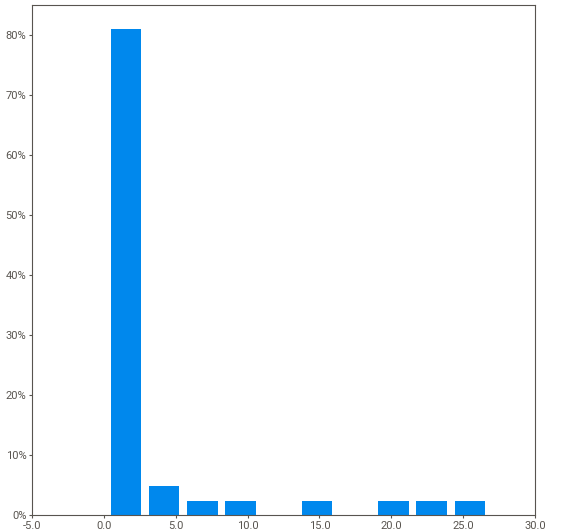
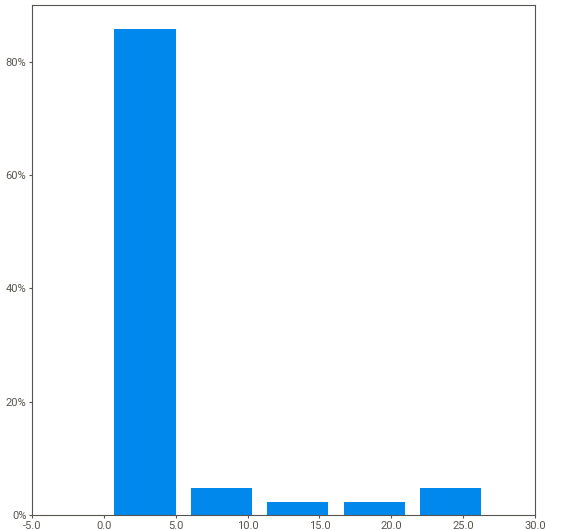
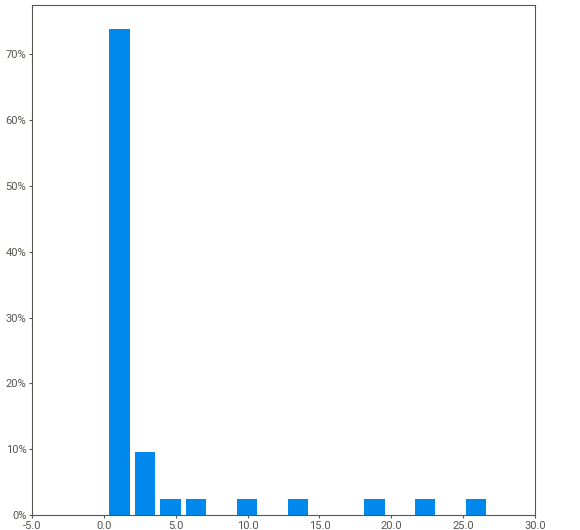
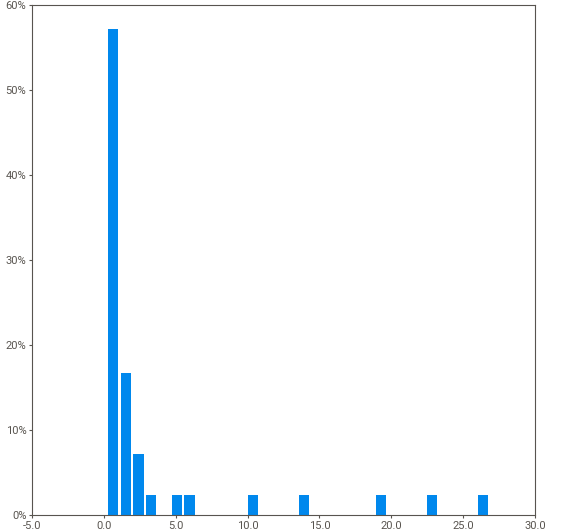
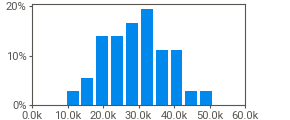
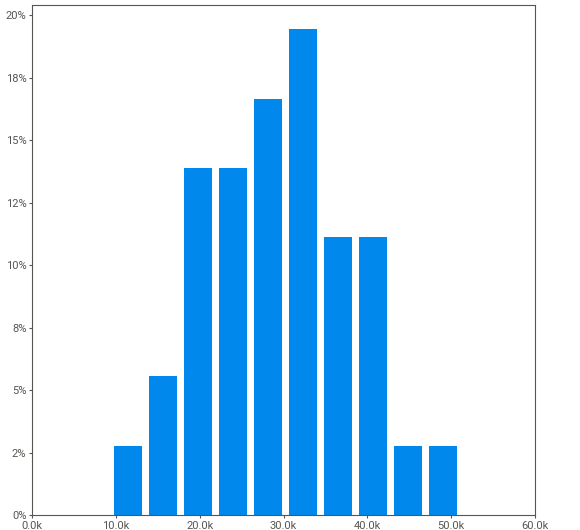
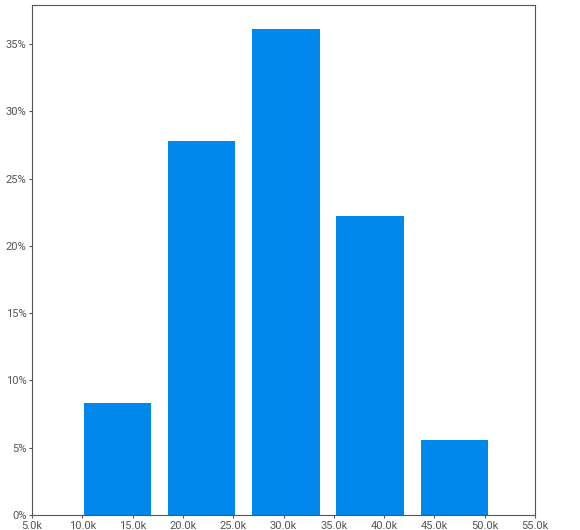
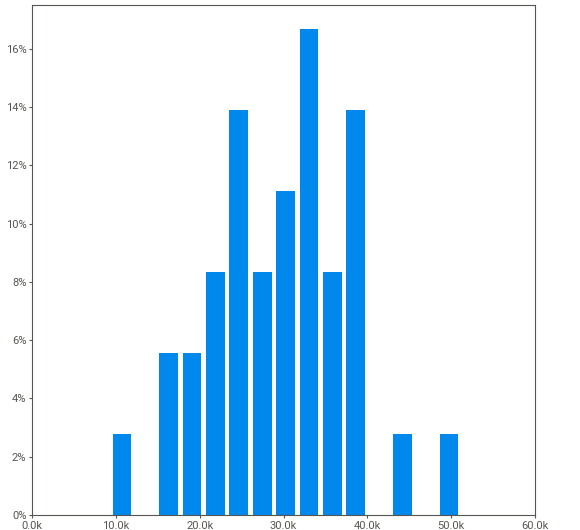
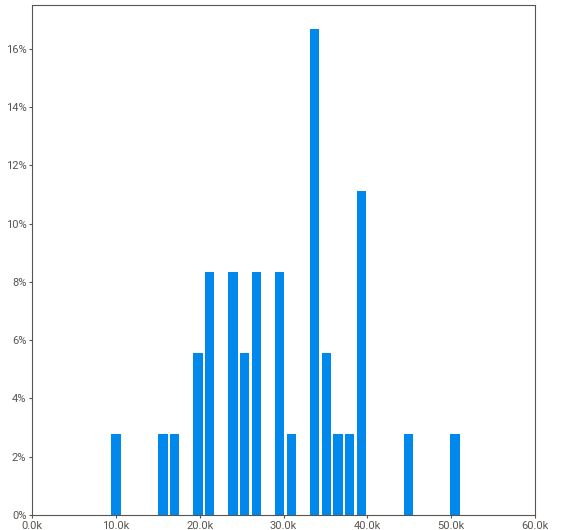
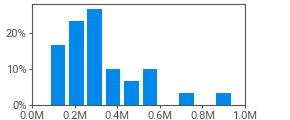
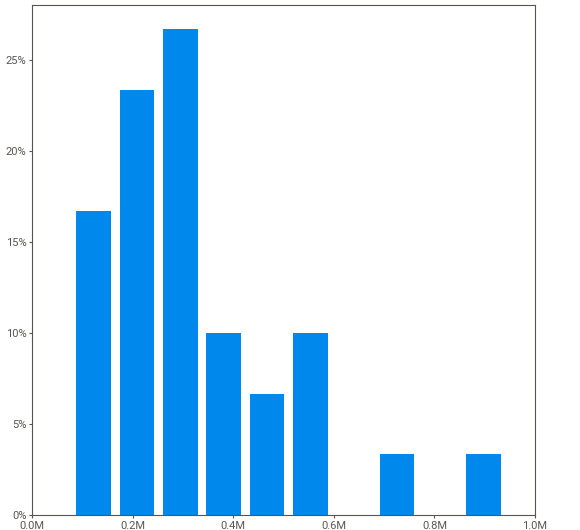
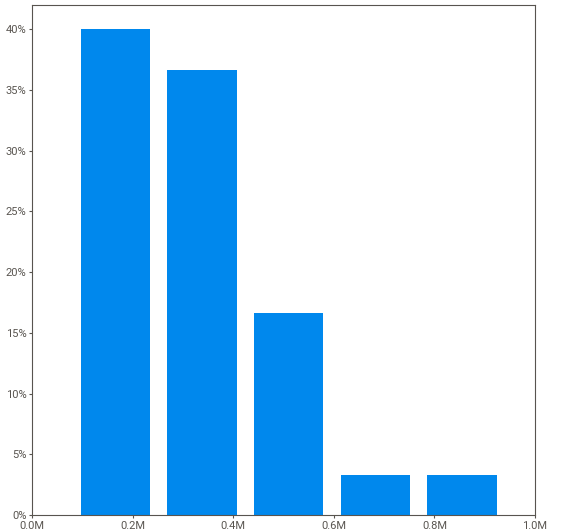
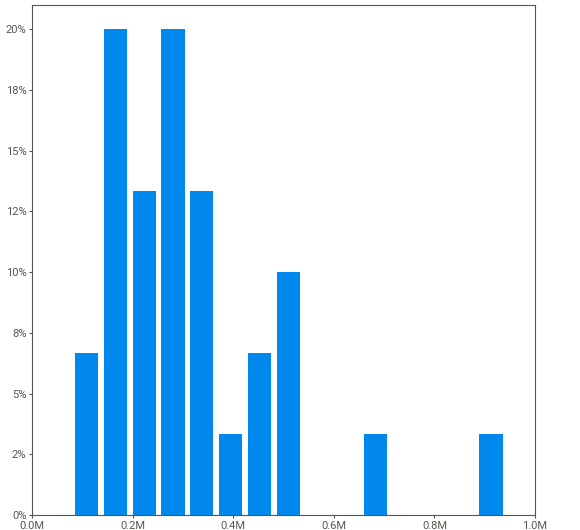
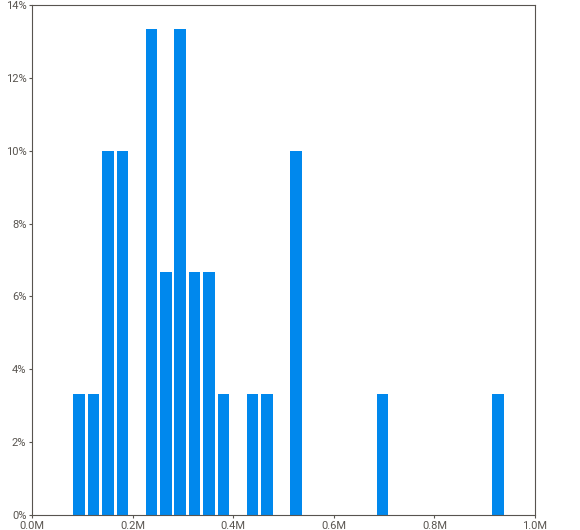
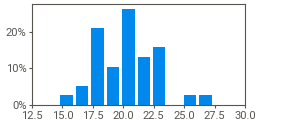
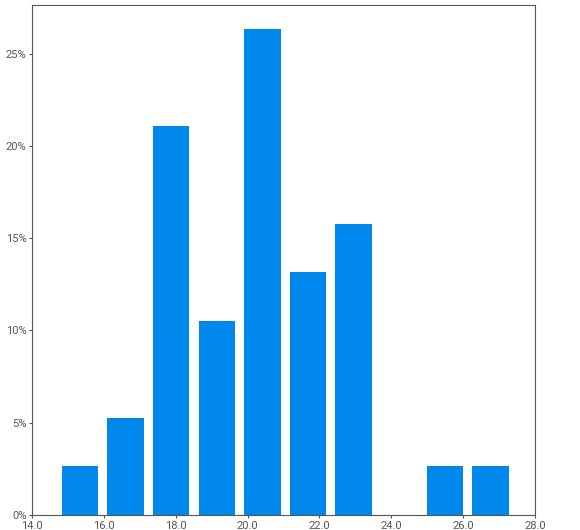
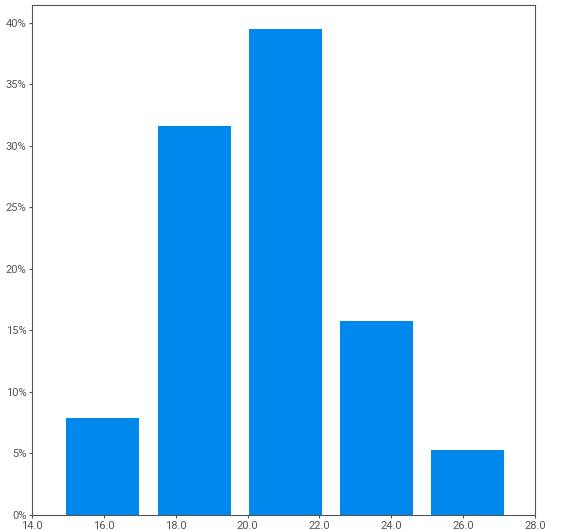
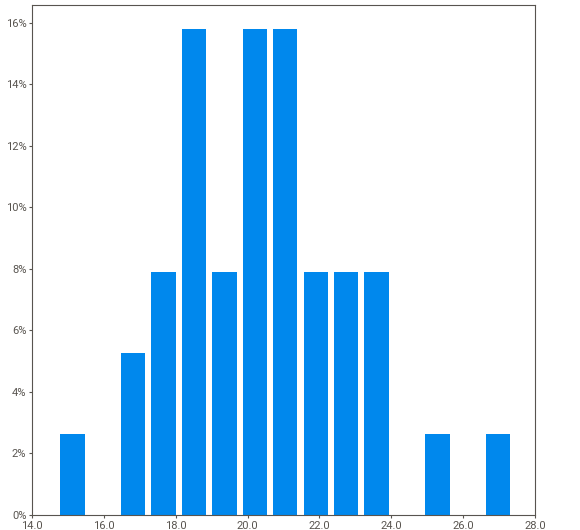
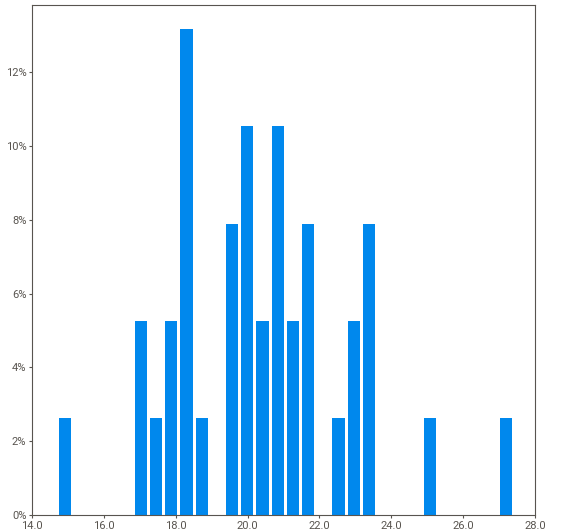
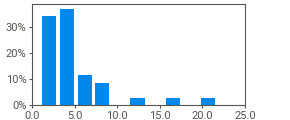
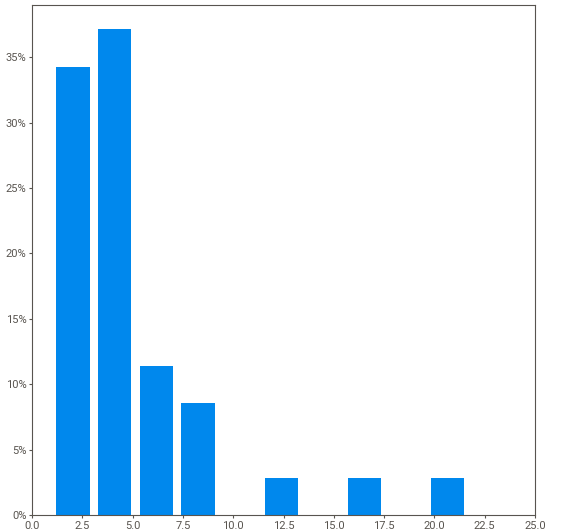
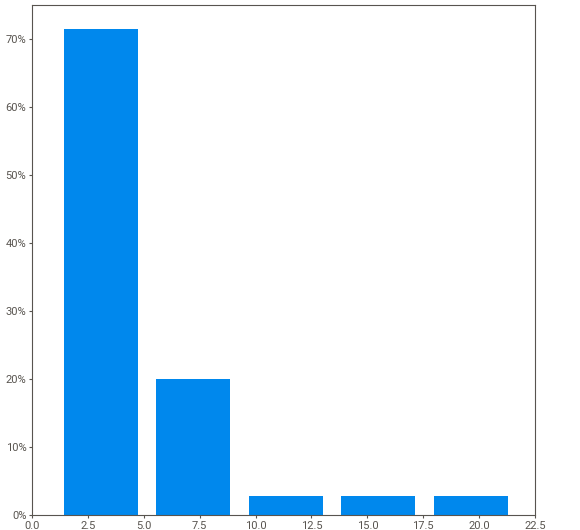
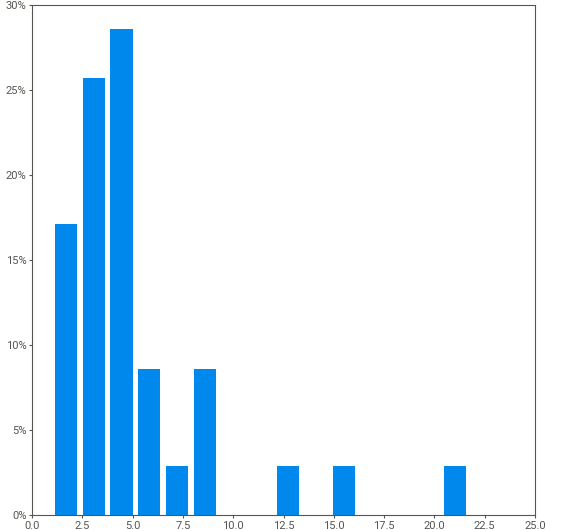
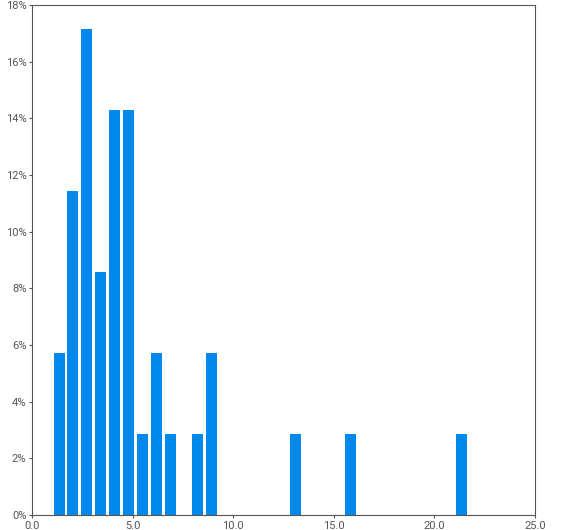
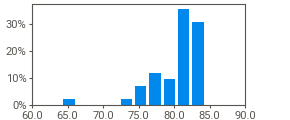
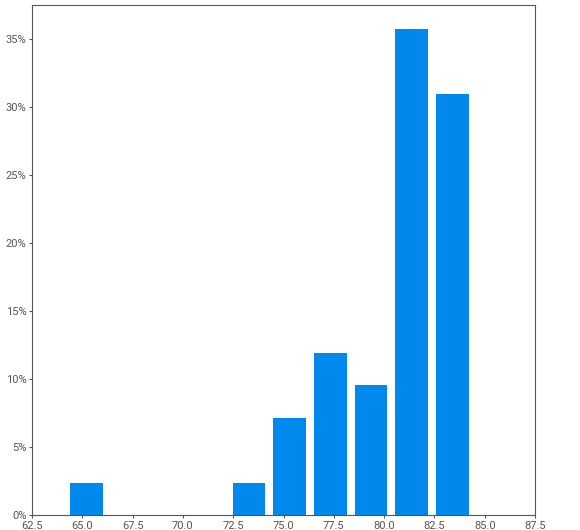
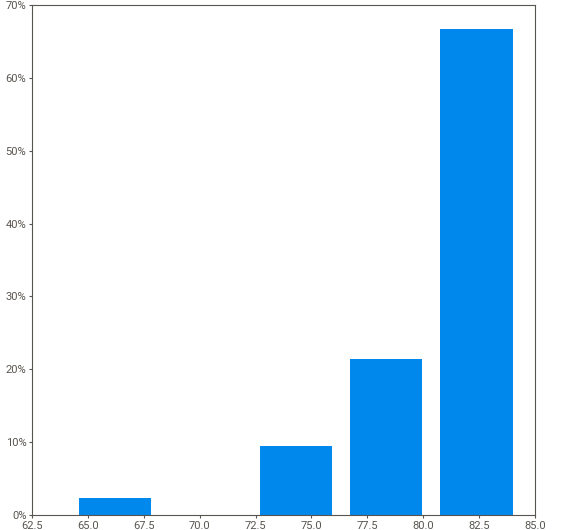
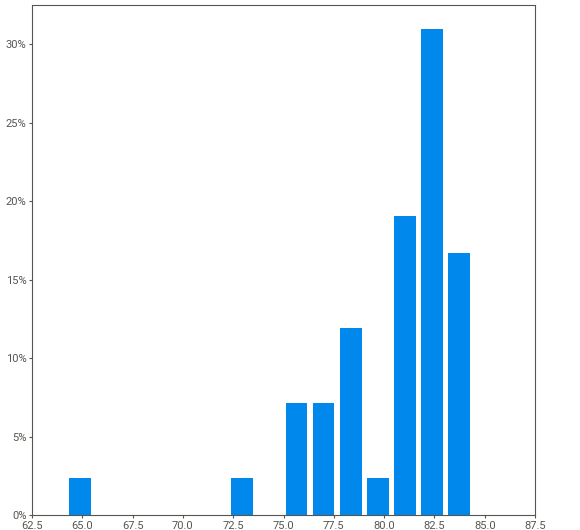
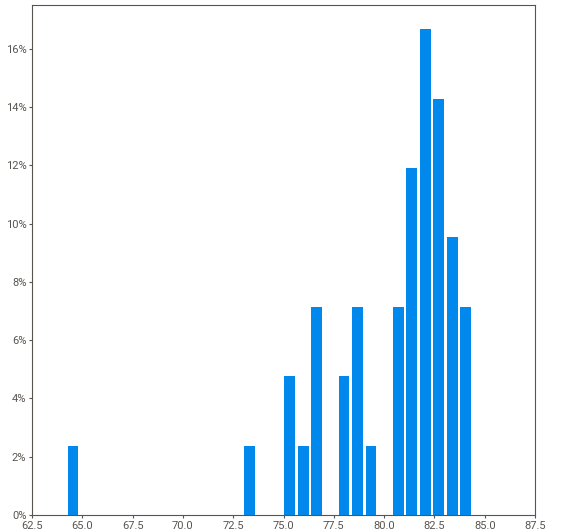
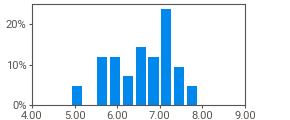
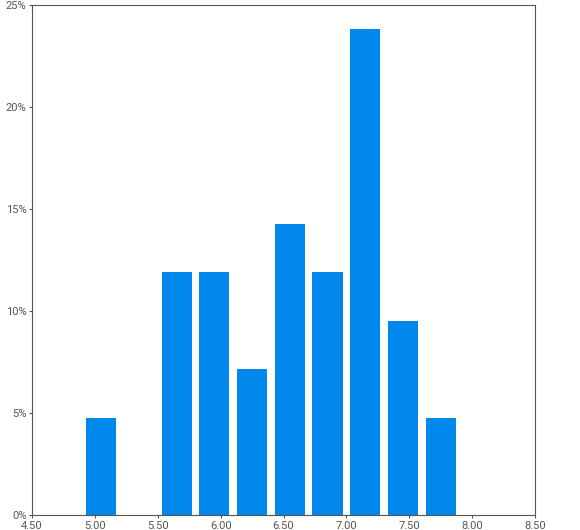
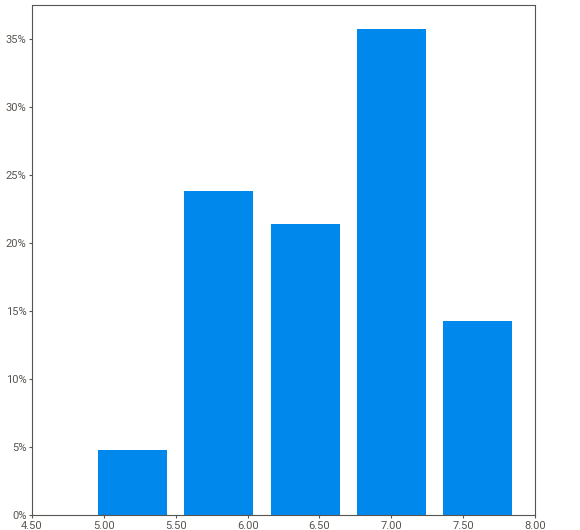
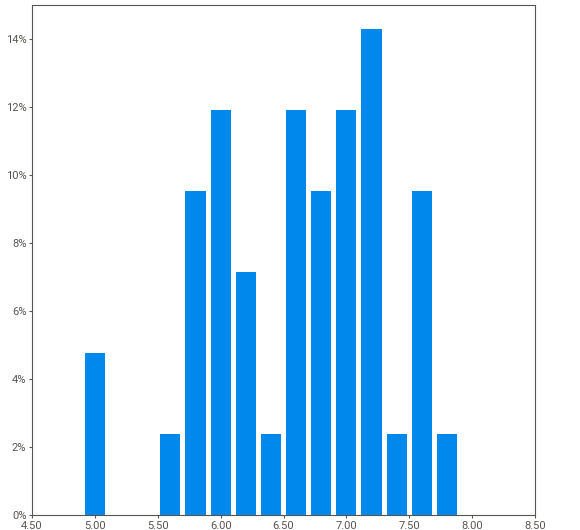
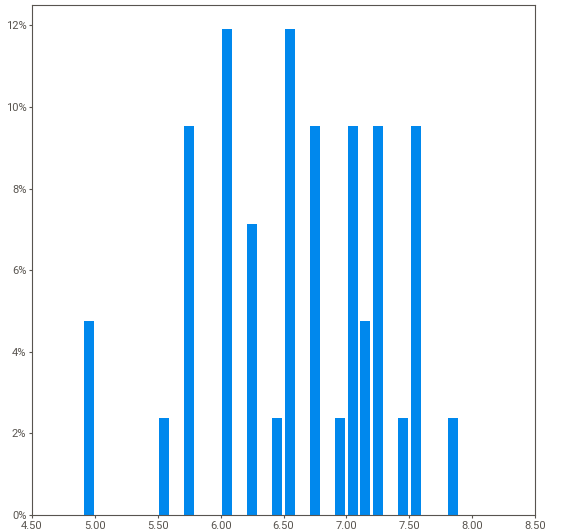
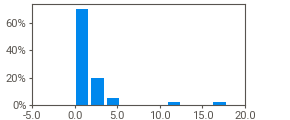
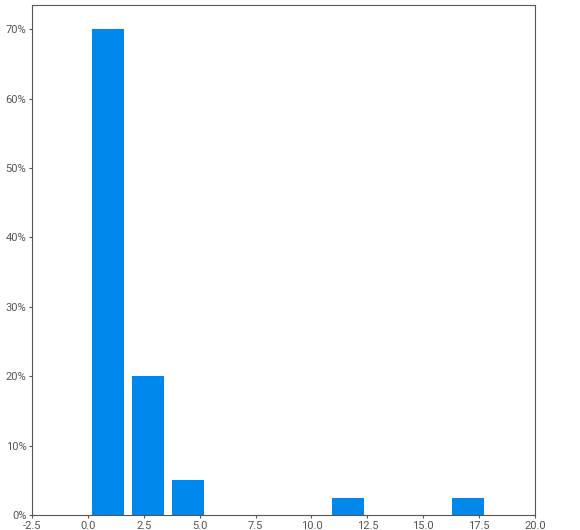
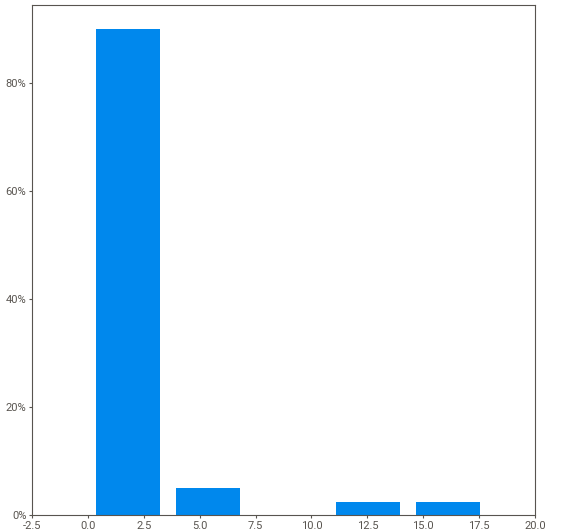
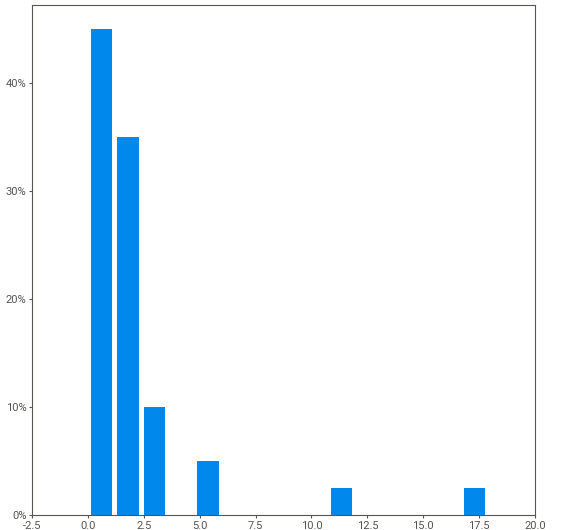
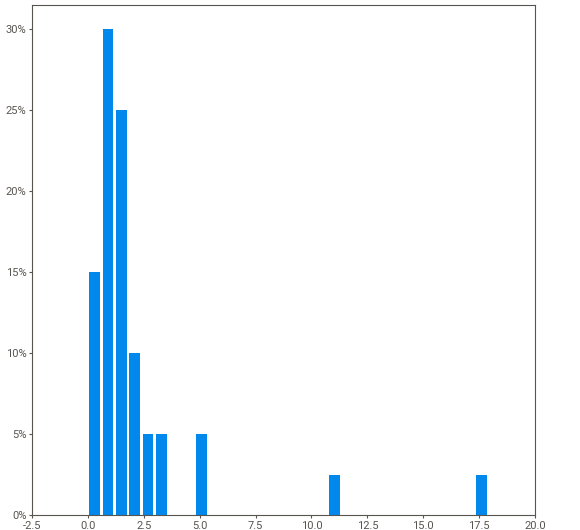
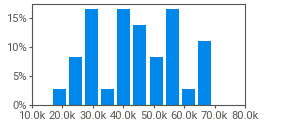
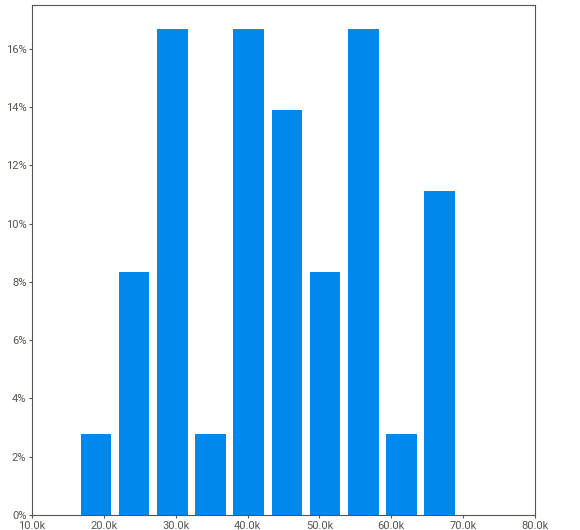
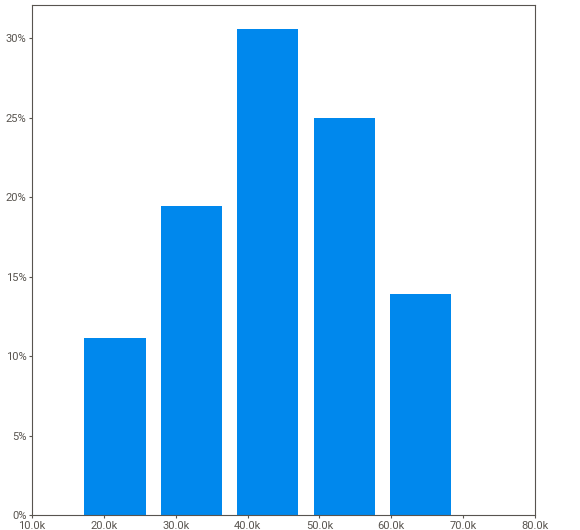
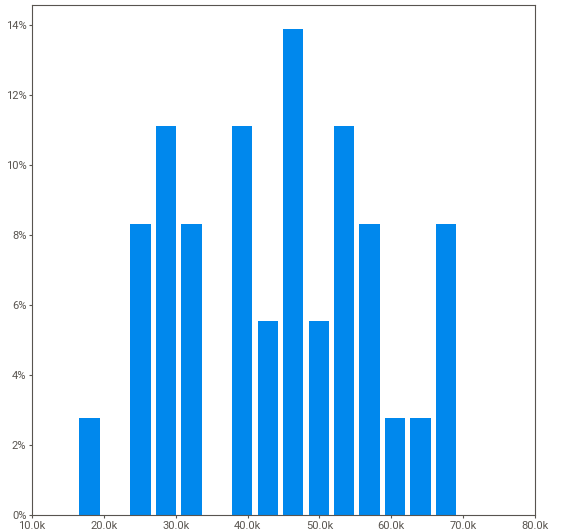
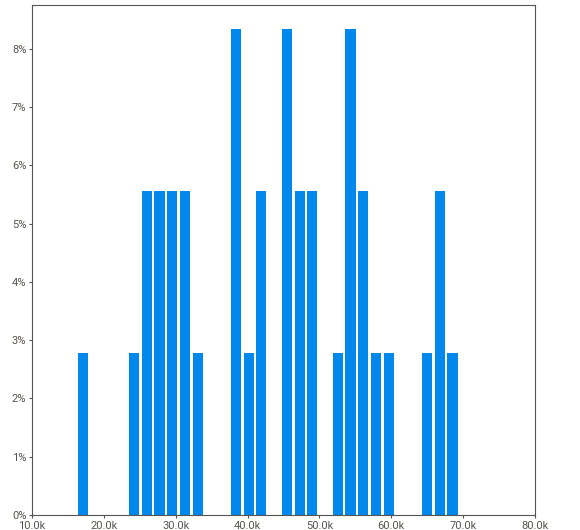
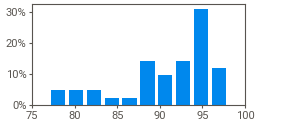
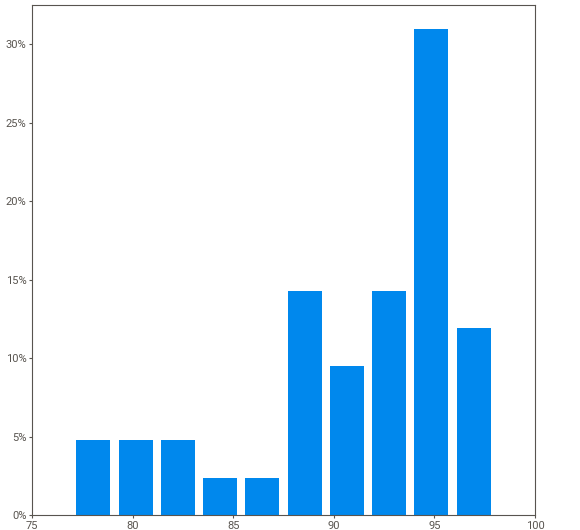
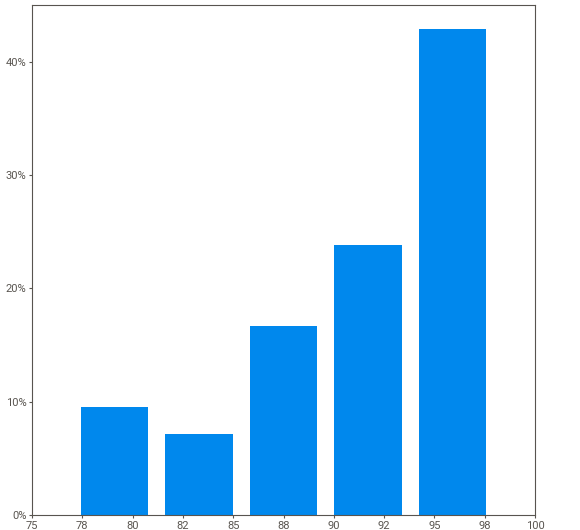
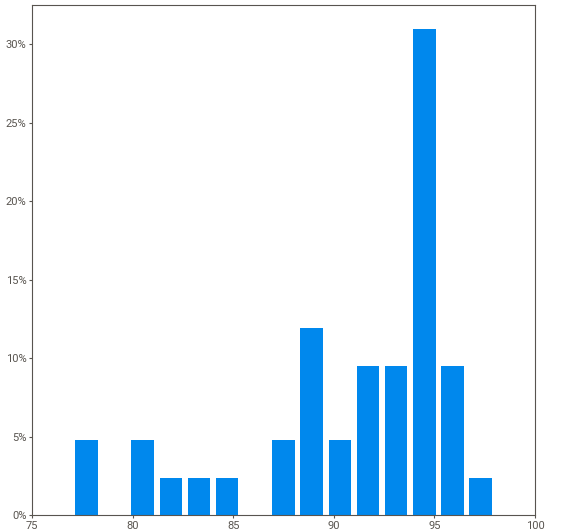
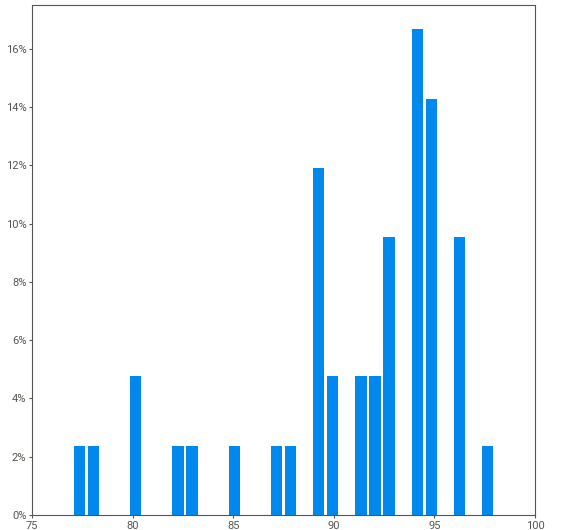
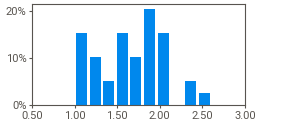
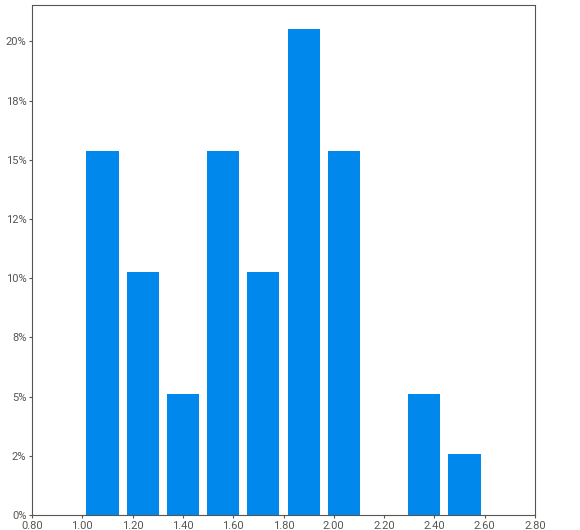
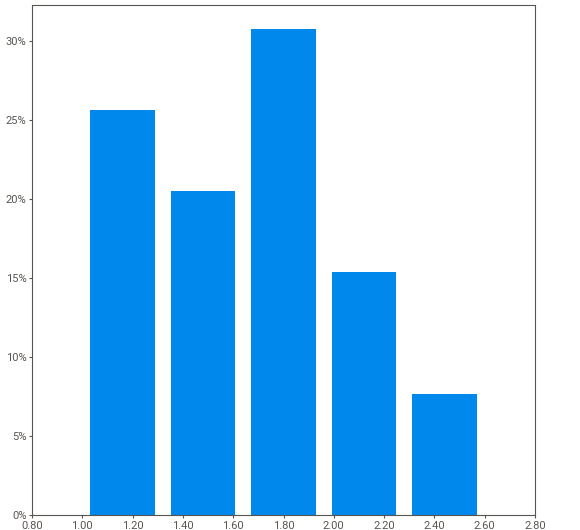
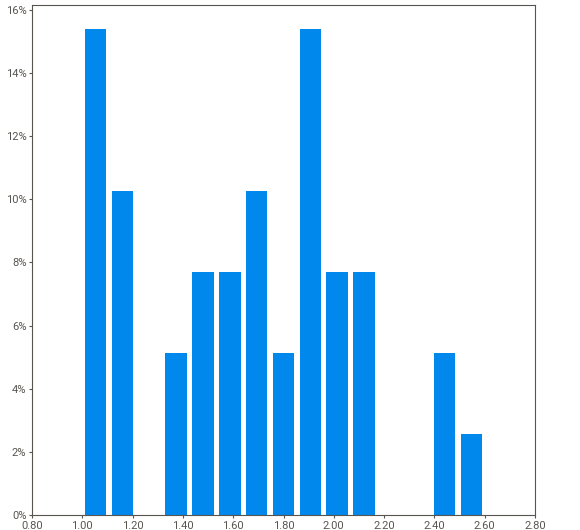
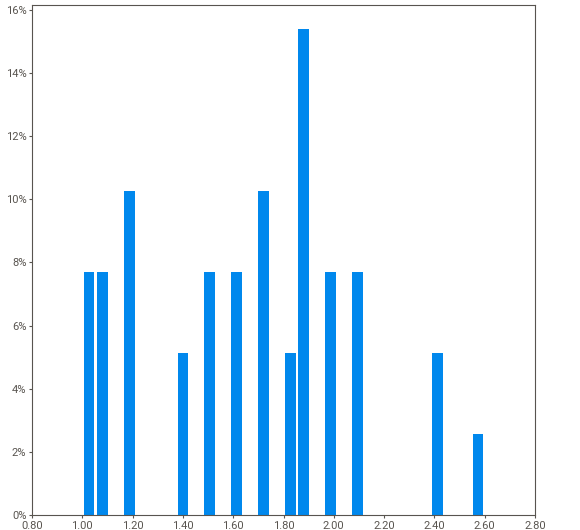
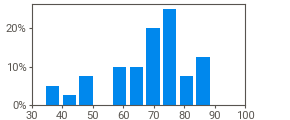
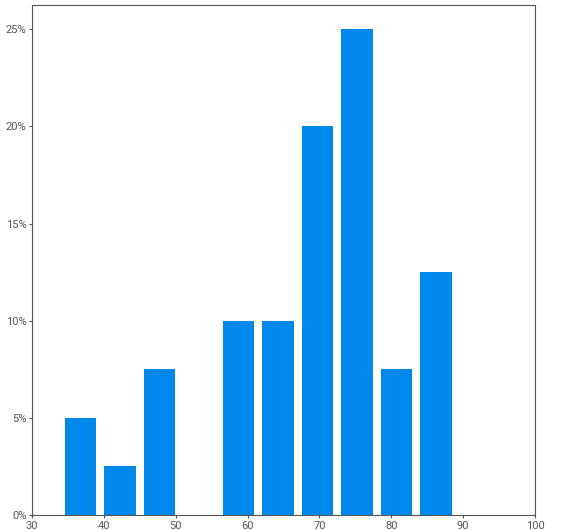
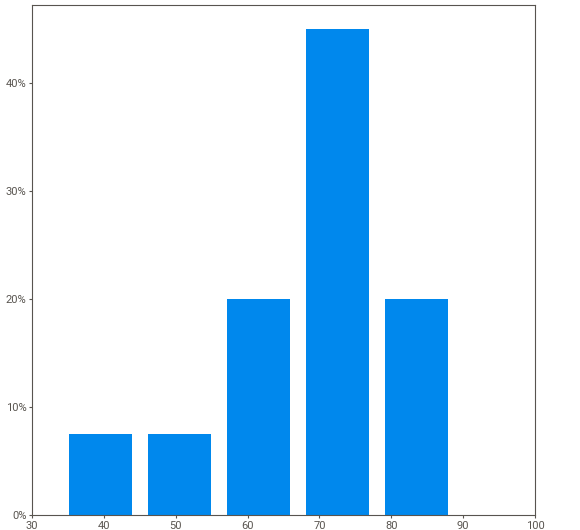
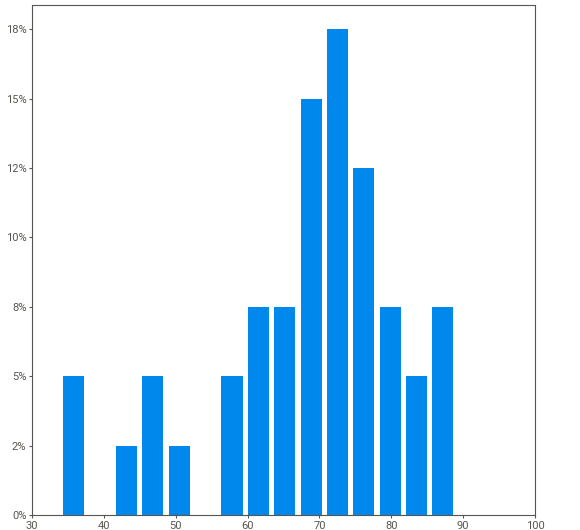
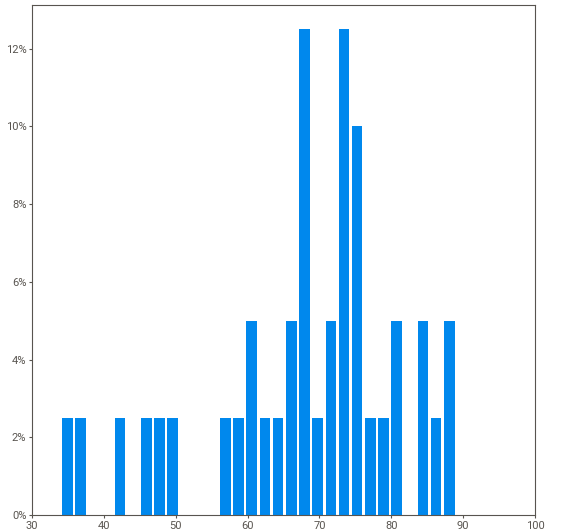
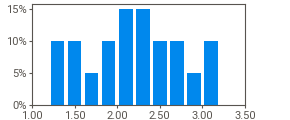
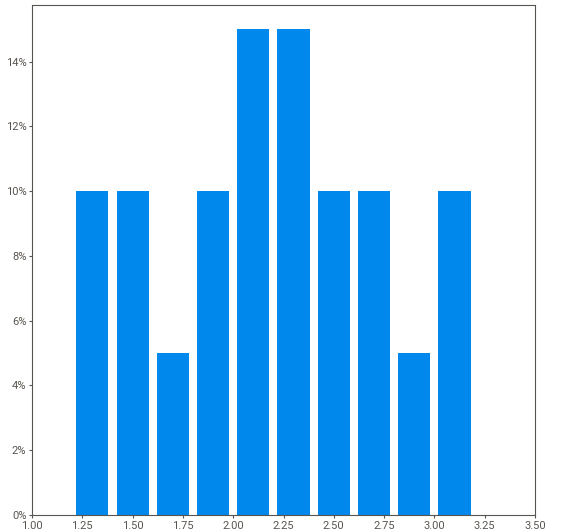
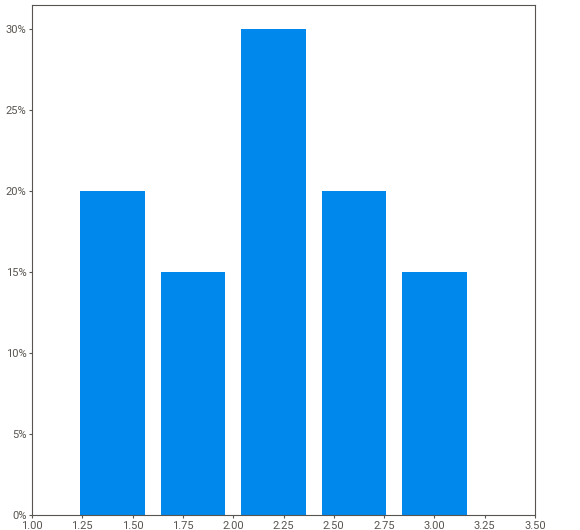
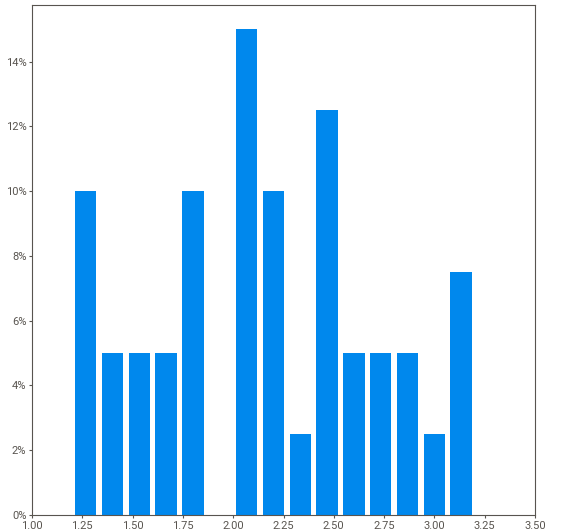
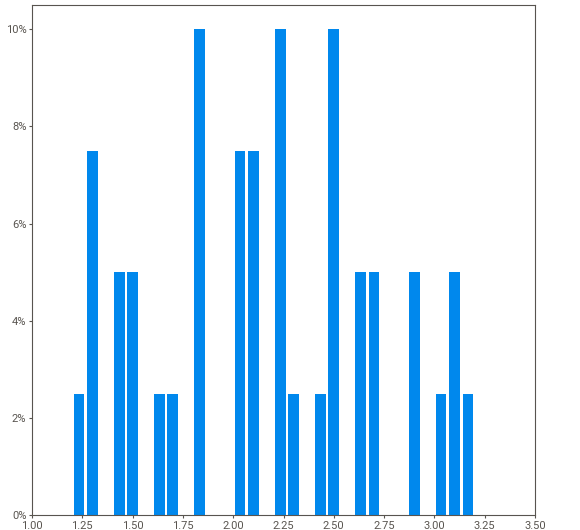
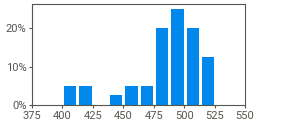
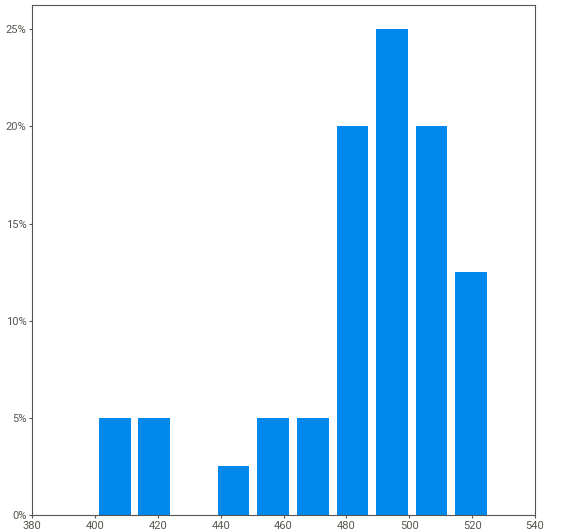
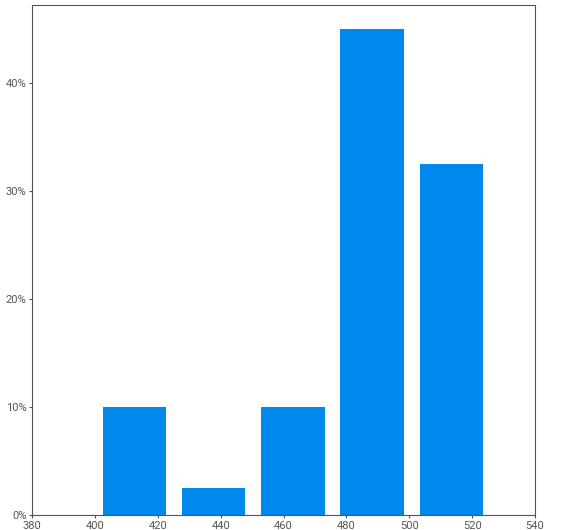
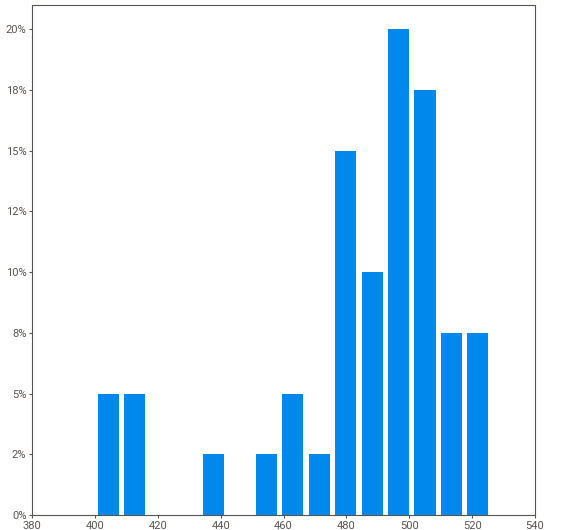
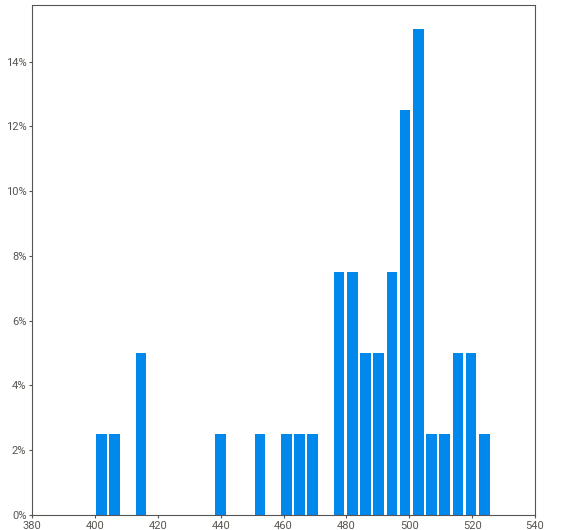
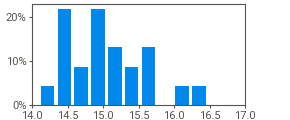
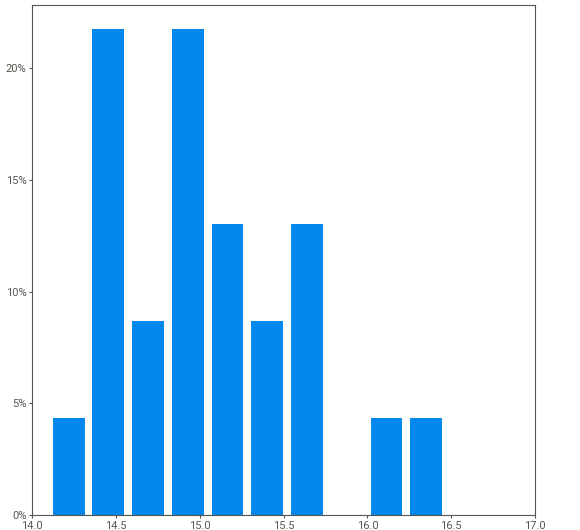
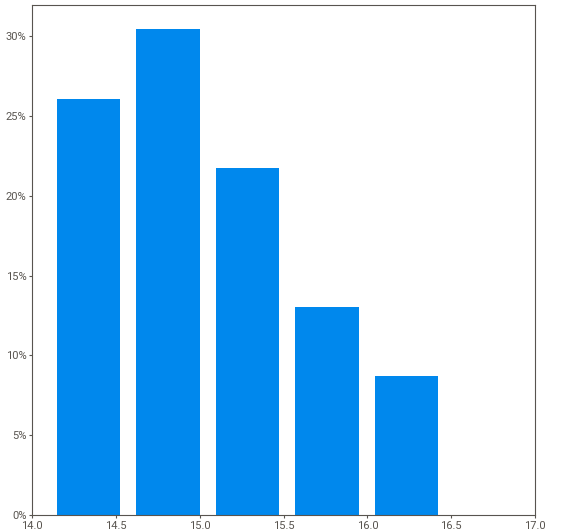
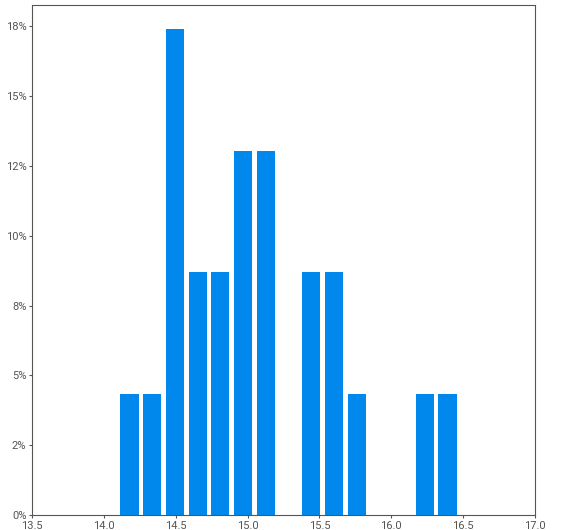
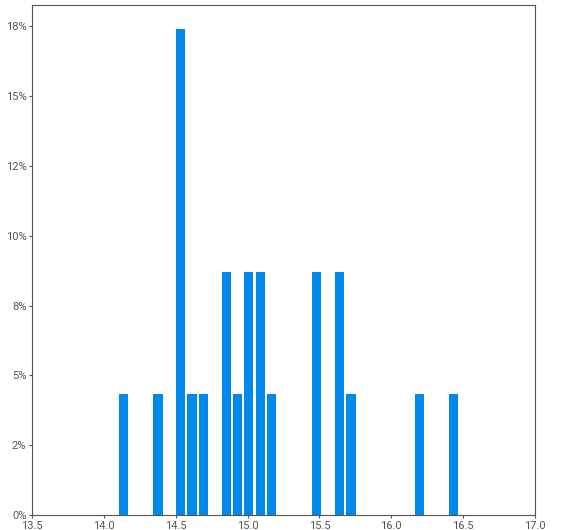
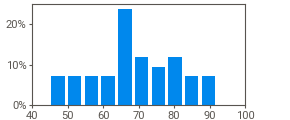
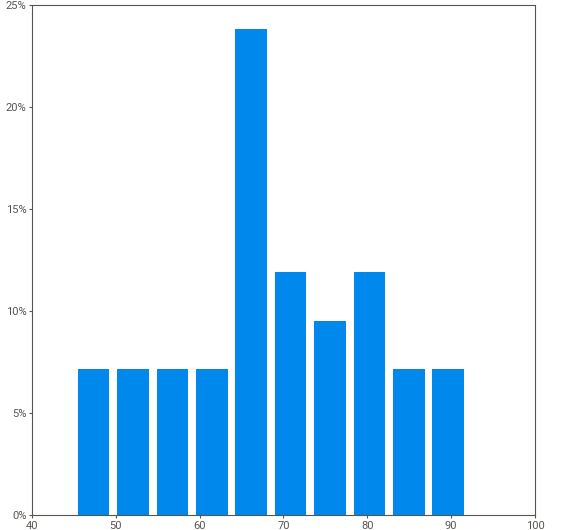
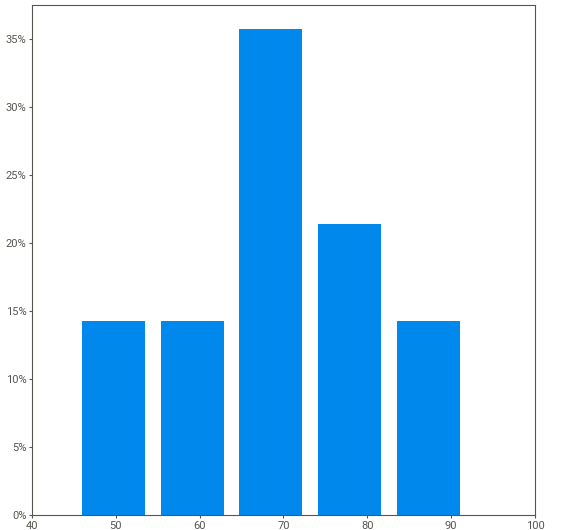
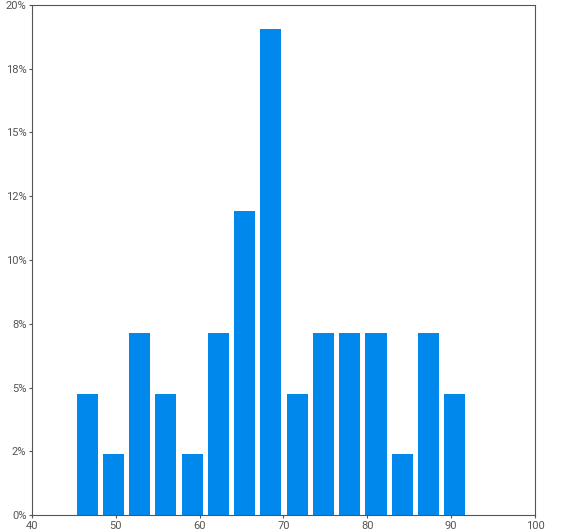
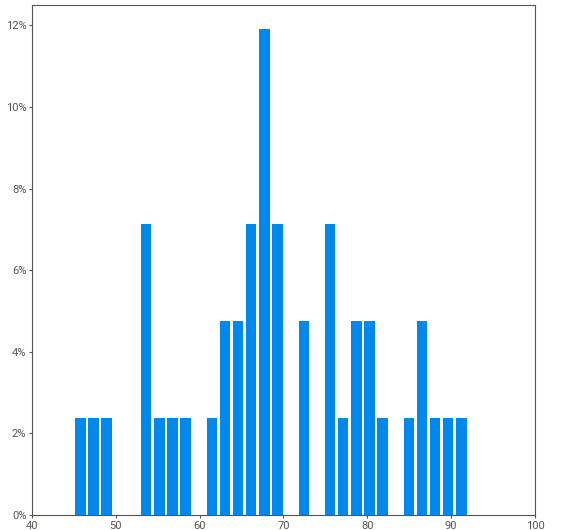
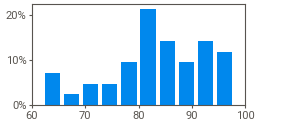
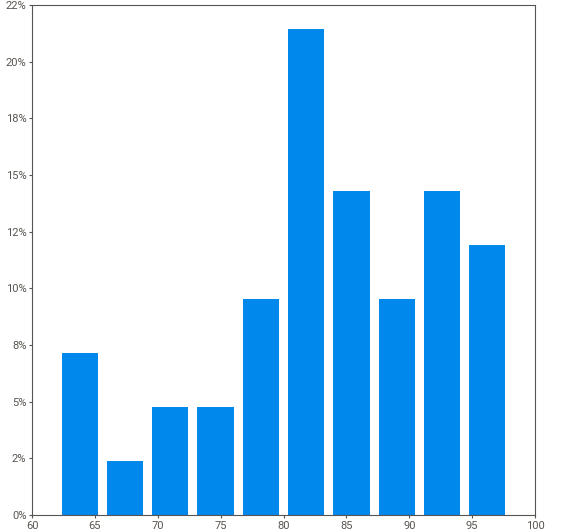
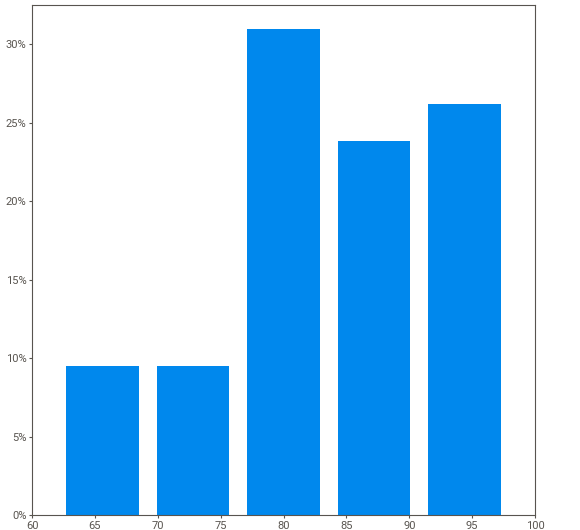
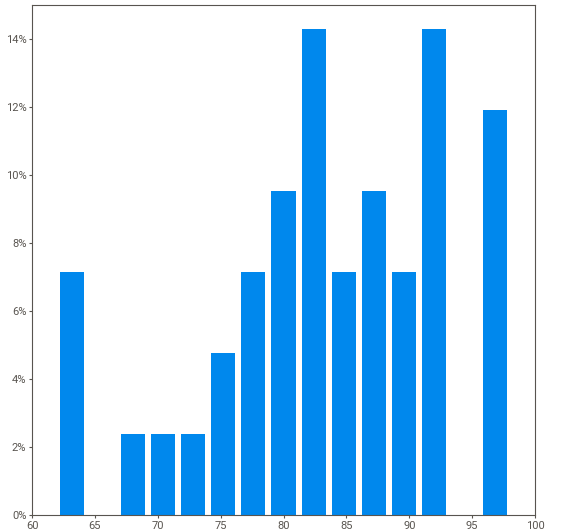
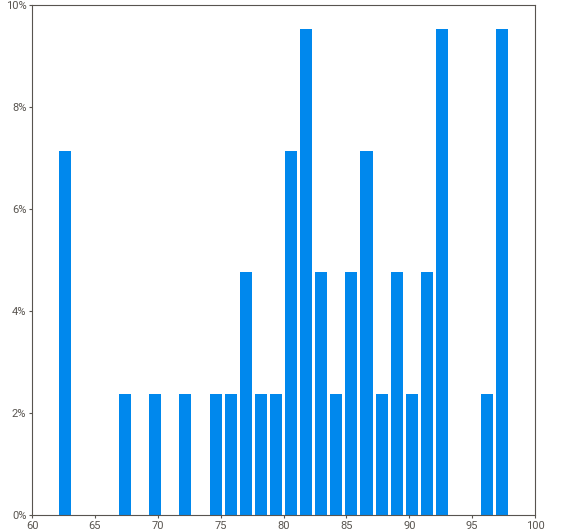
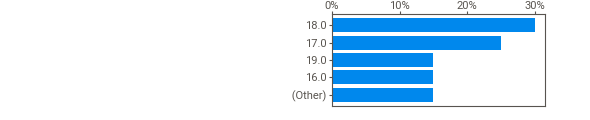
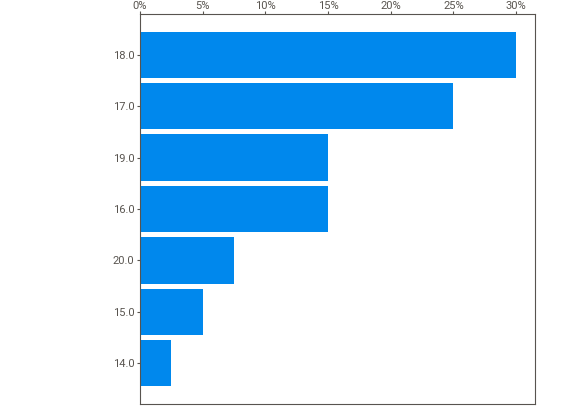
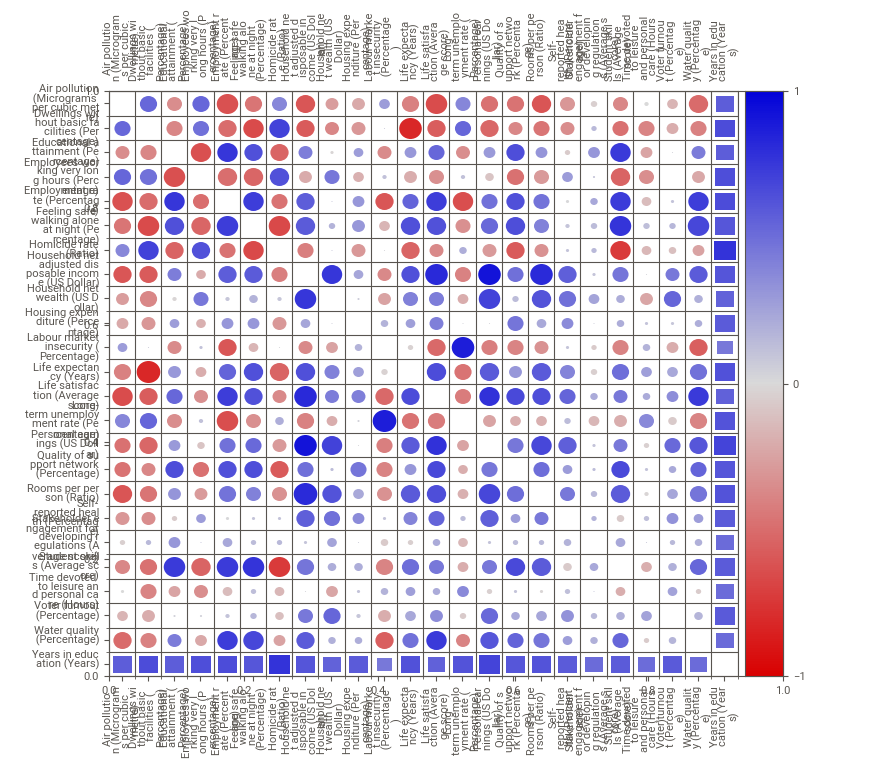
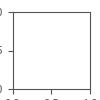

In [16]:
report=sv.analyze(df_oecd)
report.show_notebook()

While the level of missingness is generally reasonable (most variables have a percentage of missingness around 5% and the variable with the most missingness i.e Time devoted to leisure and personal care has 45% of missing values), some variables are also skewed (the variable with the most positive skew is long-term unemployment rate at 3.92 and the variable with the highest negative skew is life expectancy at -2.15), so we can't use imputation techniques that might assume normality, be sensitive to outliers or skew. So, we'll go with Random Forest imputation.

We'll have to be careful though: our data contains categorical features (`Country`, `LOCATION`), which we won't be using in the imputation. We'll only use numerical features in the imputation this time.

In [17]:
# Identify categorical and numeric columns
categorical_cols = ['Country', 'LOCATION']
numeric_cols = df_oecd.columns.difference(categorical_cols)  # All except 'Country' and 'LOCATION'

# Split dataset
df_cat = df_oecd[categorical_cols]  # Keep categorical columns
df_num = df_oecd[numeric_cols]  # Only numerical columns
# Define Random Forest Imputer
rf_imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=100, random_state=42), 
                              max_iter=10, random_state=42)

# Fit and transform only numerical columns
df_num_imputed = pd.DataFrame(rf_imputer.fit_transform(df_num), columns=df_num.columns)

# Check if missing values remain
print("Missing values after RF Imputation:\n", df_num_imputed.isnull().sum().sum())  # Should be 0

# Merge categorical and imputed numerical columns back
df_final = pd.concat([df_cat, df_num_imputed], axis=1)

Missing values after RF Imputation:
 0


Let's quickly check the distributions of the imputed variables before and after imputation:

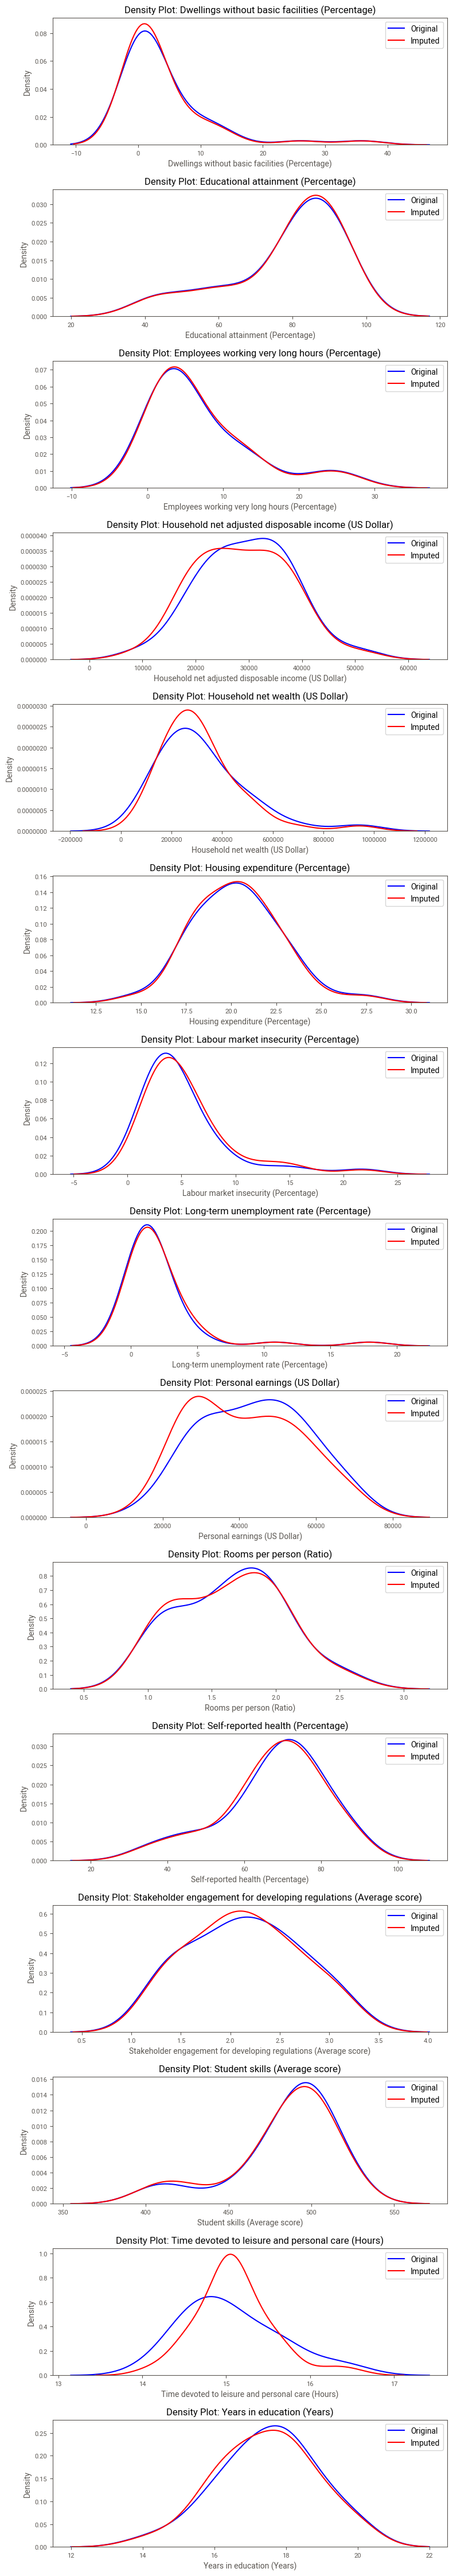

In [ ]:


def compare_distributions(original_df, imputed_df, columns):
    fig, axes = plt.subplots(len(columns), 1, figsize=(8, len(columns) * 3))

    for i, col in enumerate(columns):
        sns.kdeplot(original_df[col].dropna(), label="Original", ax=axes[i], color="blue")
        sns.kdeplot(imputed_df[col], label="Imputed", ax=axes[i], color="red")
        axes[i].set_title(f"Density Plot: {col}")
        axes[i].legend()

    plt.tight_layout()
    plt.show()

# Compare distributions for missing columns
missing_cols = df_num.columns[df_num.isnull().sum() > 0]
compare_distributions(df_num, df_num_imputed, missing_cols)

Let's check the data correlation before and after the imputation:

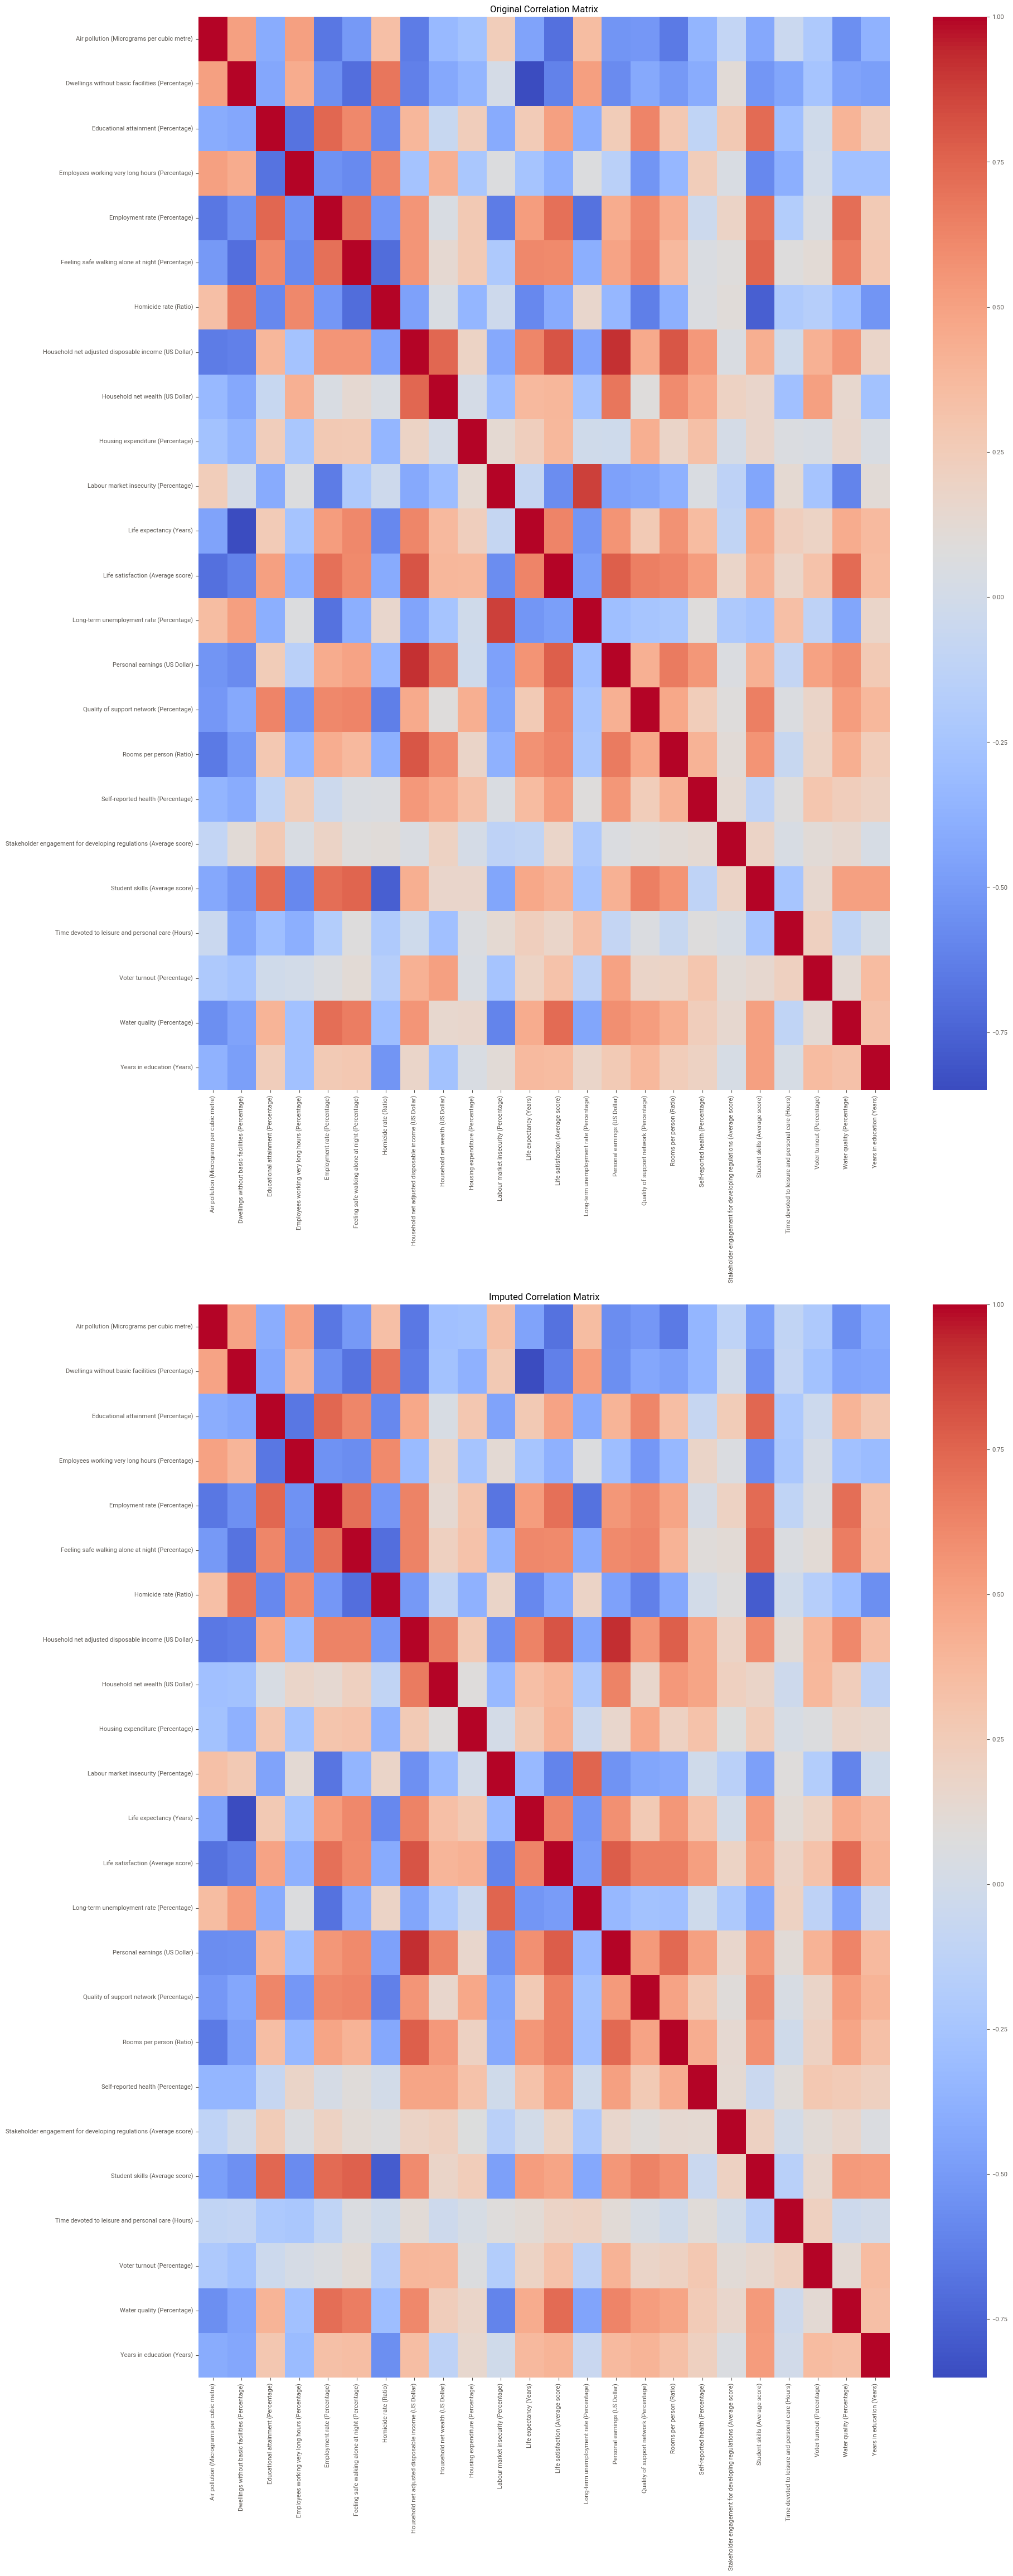

In [19]:
def compare_correlations(original_df, imputed_df):
    fig, axes = plt.subplots(2, 1, figsize=(20, 55))

    sns.heatmap(original_df.corr(), cmap="coolwarm", annot=False, ax=axes[0])
    axes[0].set_title("Original Correlation Matrix")

    sns.heatmap(imputed_df.corr(), cmap="coolwarm", annot=False, ax=axes[1])
    axes[1].set_title("Imputed Correlation Matrix")

    plt.show()

compare_correlations(df_num, df_num_imputed)

### Anomaly detection with DBSCAN

We've already seen earlier (in the stock example) that DBSCAN simply treats outliers or anomalies as a "separate cluster", that points that are not core or border points are labeled as outliers/anomalies and that therefore the number/extent of anomalies directly relates to the DSBCAN parameters chosen (i.e `eps` and `minPts`).

If you want to find out more about what to do when you get new data and about other clustering-based anomaly detection techniques, head [this way](https://towardsdatascience.com/best-clustering-algorithms-for-anomaly-detection-d5b7412537c8).

Let's go back to our better life indicators example.

Let's first scale our features:

In [20]:
scaled_final=StandardScaler().fit_transform(df_final[numeric_cols])
df_final_scaled = pd.concat([df_cat,pd.DataFrame(scaled_final, columns=numeric_cols)],axis=1)

For simplicity, we'll only look at two variables in our dataset: life satisfaction and labour market insecurity.


In [21]:
p = ggplot(df_final_scaled, aes(x='Labour market insecurity (Percentage)', y='Life satisfaction (Average score)')) + \
        geom_point(size=3, alpha=0.7, tooltips=layer_tooltips()
        .line("Country: @Country")) + \
        ggtitle("Life Satisfaction vs. Labour market insecurity") + \
        xlab("Labour market insecurity (Percentage)") + \
        ylab("Life satisfaction (Average score)")
p.show()

Let's see if we can determine optimal parameters for DBSCAN.

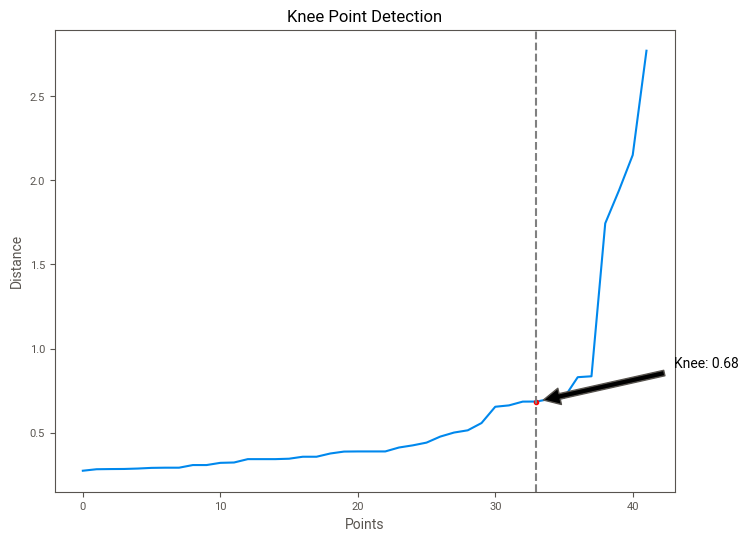

The value of the knee is: 0.6848372147115853


In [22]:
nearest_neighbors_oecd_2d = NearestNeighbors(n_neighbors=5)
neighbors_oecd_2d = nearest_neighbors_oecd_2d.fit(df_final_scaled[['Labour market insecurity (Percentage)','Life satisfaction (Average score)']])
distances_oecd_2d, indices_oecd_2d = neighbors_oecd_2d.kneighbors(df_final_scaled[['Labour market insecurity (Percentage)','Life satisfaction (Average score)']])
distances_oecd_2d = np.sort(distances_oecd_2d[:, 4], axis=0)

# Find the knee using KneeLocator
i = np.arange(len(distances_oecd_2d))
knee = KneeLocator(i, distances_oecd_2d, S=1, curve='convex', direction='increasing', interp_method='polynomial')

# Create the plot
fig = plt.figure(figsize=(8, 6))
plt.plot(i, distances_oecd_2d)
plt.xlabel("Points")
plt.ylabel("Distance")
plt.title("Knee Point Detection")

# Get knee coordinates
knee_index_oecd_2d = knee.knee
knee_value_oecd_2d = distances_oecd_2d[knee_index_oecd_2d]

# Add knee point marker
plt.plot(knee_index_oecd_2d, knee_value_oecd_2d, 'ro')

# Add annotation with arrow
plt.annotate(f"Knee: {knee_value_oecd_2d:.2f}",
             xy=(knee_index_oecd_2d, knee_value_oecd_2d),
             xytext=(knee_index_oecd_2d + 10, knee_value_oecd_2d + 0.2),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Add vertical line at knee
plt.axvline(x=knee_index_oecd_2d, color='gray', linestyle='--')

# Display the plot
plt.show()

# Print the knee value
print(f"The value of the knee is: {knee_value_oecd_2d}")

The point of maximum curvature is around 0.68, which sets our `eps` value...

Let's now run DBSCAN.

In [23]:
dbscan_oecd_2d = DBSCAN(eps=0.68, min_samples=5)
df_final_scaled['DBSCAN Cluster 2d'] = dbscan_oecd_2d.fit_predict(df_final_scaled[['Labour market insecurity (Percentage)','Life satisfaction (Average score)']])

Let's visualise our results:

In [24]:
# DBSCAN Plot
dbscan_plot_oecd_2d = (
    ggplot(df_final_scaled, aes(x='Labour market insecurity (Percentage)', y='Life satisfaction (Average score)', color="DBSCAN Cluster 2d"))
    + geom_point(size=5, alpha=0.7,tooltips=layer_tooltips()
            .line("Country: @Country"))
    + scale_color_discrete()
    + ggtitle("DBSCAN Clustering: Life Satisfaction vs. Labour market insecurity")
    + xlab("Labour market insecurity (Percentage)")
    + ylab("Life Satisfaction (Average score)")
    + theme_minimal()
)

dbscan_plot_oecd_2d.show()

#### (Bonus) What if we wanted to include more features than just the two from earlier?

We would need to select features. Our dataset has 24 numerical features for 42 observations: that's too many features for our models.

To select features, we could simply use a combination of variance thresholding and correlation thresholding i.e start by dropping features with low variance and among the features remaining, keep those that are least correlated with each other so that we keep the number of features we need.

In [ ]:
def select_features(df, n_features=10):
    """
    Select features based on variance and correlation using functional approach.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The input dataset with features as columns
    n_features : int
        Number of features to select
    
    Returns:
    --------
    list
        Names of selected features
    """
    # Step 1: Standardize the data
    X_scaled = StandardScaler().fit_transform(df)
    X_scaled_df = pd.DataFrame(X_scaled, columns=df.columns)
    
    # Step 2: Calculate variances
    variances = X_scaled_df.var().sort_values(ascending=False)
    
    # Step 3: Calculate correlation matrix
    corr_matrix = df.corr().abs()
    
    # Step 4: Select features
    selected = [variances.index[0]]  # Start with highest variance feature
    
    # Iteratively select features with minimal correlation to already selected features
    for _ in range(1, min(n_features, len(df.columns))):
        # Get remaining candidates
        candidates = set(df.columns) - set(selected)
        if not candidates:
            break
            
        # Find feature with minimal maximum correlation to already selected features
        next_feature = min(
            candidates,
            key=lambda x: max(corr_matrix.loc[x, selected])
        )
        selected.append(next_feature)
        
    return selected

selected_features = select_features(df_final[numeric_cols],n_features=6)
df_selected = pd.concat([df_cat,df_final[selected_features]],axis=1)

Just as before, we would first scale our features before applying DBSCAN:

In [ ]:
scaled_features=StandardScaler().fit_transform(df_selected[selected_features])
scaled_selected = pd.concat([df_cat,pd.DataFrame(scaled_features, columns=selected_features)],axis=1)

We now have 6 numerical features in our dataset so we need to choose `minPts` at least equal to 12.

Then, we can determine `eps` just as previously using the $k$-distance plot:

In [ ]:
nearest_neighbors_oecd = NearestNeighbors(n_neighbors=12)
neighbors_oecd = nearest_neighbors_oecd.fit(scaled_selected[selected_features])
distances_oecd, indices_oecd = neighbors_oecd.kneighbors(scaled_selected[selected_features])
distances_oecd = np.sort(distances_oecd[:, 11], axis=0)

# Find the knee using KneeLocator
i = np.arange(len(distances_oecd))
knee = KneeLocator(i, distances_oecd, S=1, curve='convex', direction='increasing', interp_method='polynomial')

# Create the plot
fig = plt.figure(figsize=(8, 6))
plt.plot(i, distances_oecd)
plt.xlabel("Points")
plt.ylabel("Distance")
plt.title("Knee Point Detection")

# Get knee coordinates
knee_index_oecd = knee.knee
knee_value_oecd = distances_oecd[knee_index_oecd]

# Add knee point marker
plt.plot(knee_index_oecd, knee_value_oecd, 'ro')

# Add annotation with arrow
plt.annotate(f"Knee: {knee_value_oecd:.2f}",
             xy=(knee_index_oecd, knee_value_oecd),
             xytext=(knee_index_oecd + 10, knee_value_oecd + 0.2),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Add vertical line at knee
plt.axvline(x=knee_index_oecd, color='gray', linestyle='--')

# Display the plot
plt.show()

# Print the knee value
print(f"The value of the knee is: {knee_value_oecd}")  

The point of maximum curvature is around 3.04, which sets our `eps` value...

Then, we run DBSCAN with the selected parameters.

In [ ]:
dbscan_oecd = DBSCAN(eps=3.04, min_samples=12)
df_selected['DBSCAN Cluster'] = dbscan_oecd.fit_predict(scaled_selected[selected_features])

The only difference from previously happens when visualising the results. You can reduce dimensionality to 2 with UMAP and visualise your results in the UMAP space:

In [ ]:
umap_model_oecd = umap.UMAP(n_components=2)
df_selected[['UMAP1', 'UMAP2']] = umap_model_oecd.fit_transform(scaled_selected[selected_features])

umap_plot = (
    ggplot(df_selected, aes(x="UMAP1", y="UMAP2", color="DBSCAN Cluster"))
    + geom_point(size=3, alpha=0.7, tooltips=layer_tooltips()
        .line("Country: @Country"))
    + scale_color_brewer(type='qual', palette="Set3")
    + ggtitle("DBSCAN clustering \n Visualisation in the UMAP space")
    + theme_minimal()
)

umap_plot.show()

### Anomaly detection with Isolation Forest

#### How Isolation Forest works:

1.  One feature within the dataset is selected

2.  A split value within the range of the selected feature is randomly selected for the instances currently in the node.

3.  The data is into two child nodes based on the split value selected in step 2.

4.  The process from steps 1 to 3 is repeated recursively for each child node until one of the following conditions is met:

-   Each leaf node has only one instance.

-   A predefined maximum depth is reached.

So, basically one tree (called isolation tree) is created per feature.

How do we then calculate anomaly scores and determine the anomalies?

The basic idea is that we account for the length of the path for each observation within a tree (we call that $h(x)$ ).

The shorter that path is, the more likely that observation is to be anomalous for that particular feature.

We could be tempted to simply take the average of path lengths (called $E[h(x)]$) over all isolation trees to get our anomaly score: however, not all features and paths are directly comparable.

So, we need a normalization term: it's based on sample size $n$ (and Binary Search Tree theory)

$$
c(n)=\begin{cases}
     2H(n-1)-2\frac{n-1}{n} \textrm{ if } n>2\\
     1 \textrm{ if } n=2\\
     0 \textrm{ otherwise}
     \end{cases}
$$

where $H(i)$ is the harmonic number that can be estimated by $ln(i) + 0.5772156649$ (Euler’s constant)

and the anomaly score is:

$$
s(x,n)=2^{-\frac{E(h(x))}{c(n)}}
$$

​The score ranges between 0 and 1, and when interpreting it, there are three scenarios:

-   If a point is an anomaly then $E[h(x)] < c(n)$ and $s → 1$

-   If a point is not an anomaly then $E[h(x)] > c(n)$ and $s → 0$ 

-   If $E[h(x)] = c(n)$ then $s = 0.5$

In other words, when the average path length of an instance is shorter than the expected average path length, the anomaly score will be closer to 1.

Any score lower than 0.5 will be identified as normal instances.

To read more about Isolation Forest, you can refer to the original paper: Fei Tony Liu, Kai Ming Ting and Zhi-Hua Zhou, ["Isolation Forest,"](https://ieeexplore.ieee.org/document/4781136) *2008 Eighth IEEE International Conference on Data Mining*, Pisa, Italy, 2008, pp. 413-422, doi: 10.1109/ICDM.2008.17

How do we implement Isolation Forest on our life satisfaction/labour insecurity-reduced dataset from earlier?


In [25]:
iso_model = IsolationForest(n_estimators=100, max_samples=256, contamination='auto', random_state=42)
iso_model.fit(df_final_scaled[['Labour market insecurity (Percentage)','Life satisfaction (Average score)']])

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_iforest.py:336: UserWarning: max_samples (256) is greater than the total number of samples (42). max_samples will be set to n_samples for estimation.
  warn(


IsolationForest(max_samples=256, random_state=42)

How do you set the parameters `ntrees`,`ndim` and `sample_size`?

-   `n_estimators` is the number of Isolation Trees used in the ensemble. A value of `100` is used in the Isolation Forest paper. Through experimentation, the researchers found this to produce good results over a variety of datasets. This would generally be the **default** value and would be particularly recommended for datasets with a number of observations lower than 10000. For larger datasets, you can increase `n_estimators` to 200-300. The idea is that more trees improve the stability of anomaly scores but increase computation time. You can try and tune this parameter to check if more trees significantly improve results.

-   `max_samples` is the number of observations used to build each tree. The idea is that smaller samples isolate anomalies more effectively. The **default** value is 256 (or the total number of observations in the dataset if the dataset has fewer than 256 observations).

-  `contamination` is a parameter that estimates the proportion of anomalies. If set to `auto`, it estimates that proportion automatically. If the dataset has very few anomalies, it may not flag enough anomalies. If you know the approximate fraction of anomalies, you can manually set it (e.g., `contamination=0.05` for 5% anomalies).

In [26]:
# Get anomaly scores (anomaly score is the opposite of anomaly probability in isolation forest)
anomaly_scores = -iso_model.decision_function(df_final_scaled[['Labour market insecurity (Percentage)','Life satisfaction (Average score)']])
# Add the scores to the dataset
df_final_scaled['anomaly_score'] = anomaly_scores
# Set anomaly threshold
threshold = 0.1

# Add an anomaly flag based on threshold
df_final_scaled['is_anomaly'] = df_final_scaled['anomaly_score'] > threshold

We plot our data with observations colored by anomaly score.

In [27]:
p1 = ggplot(df_final_scaled, aes(x='Labour market insecurity (Percentage)', y='Life satisfaction (Average score)', color='anomaly_score')) + \
     geom_point(size=2, alpha=0.7,tooltips=layer_tooltips()
            .line("Country: @Country")) + \
     scale_color_gradient(low='blue', high='red') + \
     theme_minimal() + \
     ggtitle("Isolation Forest Anomaly Detection") + \
     xlab('Labour market insecurity (Percentage)') + \
     ylab('Life satisfaction (Average score)')
p1.show()

We also plot our data, highlighting anomalies (based on the threshold we set!).

In [28]:
p2 = ggplot(df_final_scaled, aes(x='Labour market insecurity (Percentage)', y='Life satisfaction (Average score)', color='is_anomaly')) + \
     geom_point(size=2, alpha=0.7,tooltips=layer_tooltips()
            .line("Country: @Country")) + \
     scale_color_manual(values={'False': 'blue', 'True': 'red'}) + \
     theme_minimal() + \
     ggtitle("Anomaly Detection Results (Isolation Forest)") + \
     xlab("Labour market insecurity (Percentage)") + \
     ylab("Life satisfaction (Average score)")
p2.show()

#### **How do you determine the anomaly threshold?**

We previously set the anomaly threshold to a 0.1 threshold, meaning that any point with a score higher than 0.1 would be flagged as an anomaly.

More generally, the anomaly threshold determines whether a point is flagged as anomalous. How do we set it? There are several approaches to set it:

**1. Use Percentiles of Anomaly Scores**

Anomaly scores fall within the range [-1, 1] where scores closer to 1 indicate a higher likelihood of being an anomaly.

Here is how you set the anomaly threshold using percentiles:

1.  Calculate the anomaly scores for the dataset.

2.  Use a high percentile (e.g., 95th or 99th percentile) as the threshold (points with scores above this threshold are flagged as anomalies).


In [29]:
threshold = np.percentile(anomaly_scores, 95)
print(round(threshold,2))

0.15


Based on this method, you'd be setting the threshold to 0.15 (you could obviously choose a lower percentile if you want to capture more anomalies).

**2. Use the mean and standard deviation to set a threshold**

You could set the threshold to be equal to the mean of your data point plus twice their standard deviation i.e:

In [30]:
threshold = np.mean(anomaly_scores) + 2 * np.std(anomaly_scores)
print(round(threshold,2))

0.12


Based on this method, you'd be setting the threshold to 0.12 (you can obviously adjust the number of times you multiply the standard deviation by to capture more or less outliers).

**3. Visual Inspection**:

-   Plot a histogram of the anomaly scores:

In [31]:
anomaly_df = pd.DataFrame({'Anomaly Score': anomaly_scores})

p_anomaly = ggplot(anomaly_df, aes(x='Anomaly Score')) + \
    geom_histogram(bins=30) + \
    ggtitle("Distribution of Anomaly Scores") + \
    xlab("Anomaly Score") + \
    ylab("Frequency")
p_anomaly.show()

-   Identify natural separations or clusters in the scores and set the threshold accordingly

Looking at the histogram above for our data, most scores are clustered between -0.1 and 0.01 but we also have a second smaller cluster between around 0.03 to 0.08 (which we could potentially consider anomalies). It looks relatively safe to say that anomalies are points whose score is above 0.1.

#### **4. Based on Domain Knowledge**

-   Use domain expertise to decide the acceptable anomaly level.

    -   For example, if anomalies occur in 1% of observations, set the threshold such that \~1% of the points are flagged as anomalies.

🏡 **TAKE-HOME EXERCISE**: Can you apply Isolation Forest on the extended Better Life index indicators dataset?

### Anomaly detection with LOF (Local Outlier Factor)

Both Isolation Forest and DBSCAN are methods that detect global outliers. Local Outlier Factor, in contrast, identifies local outliers.

Let's start with a few definition again:

-   K-distance is the distance between a point and it's K$^{th}$ nearest neighbor.
-   K-neighbors, denoted by $N_k(A)$ is the set of points that lie in or on the circle of radius K-distance. K-neighbors can be greater or equal to the value of K.

Let's see an example:

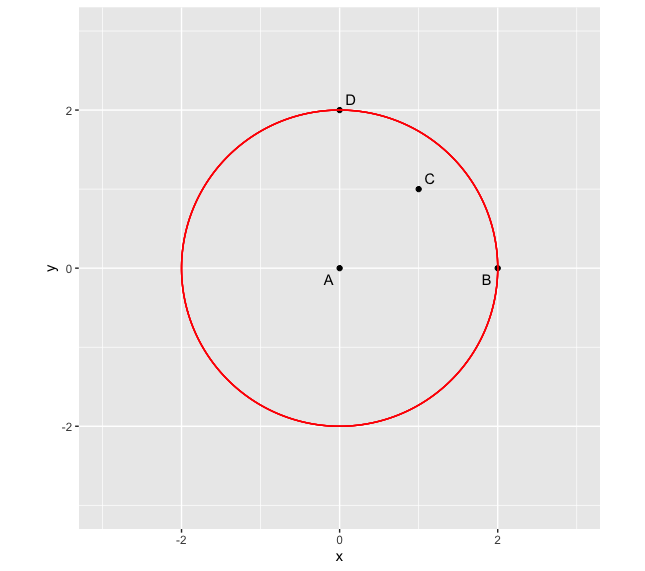{width="60%"}

Let's say we have four points: A, B, C, and D.

If K=2, K-neighbors of A include C, B and D and therefore $||N_2(A)||$ = 3.

-   Reachability distance:

    -   Given two points $x_j$ and $x_i$, it is defined as the maximum of K-distance of $x_j$ and the distance between $x_i$ and $x_j$. The distance measure is problem-specific (e.g Euclidean, Manhattan).

    Written more formally, this would look like this: $RD(x_i,x_j)=\max(\textrm{K-distance}(x_j),\textrm{distance}(x_i,x_j))$

    Said differently, if a point $x_i$ belongs to the K-neighbors of $x_j$ , the reachability distance will be K-distance of $x_j$ (blue line), otherwise the reachability distance will be the distance between $x_i$ and $x_j$ (orange line)

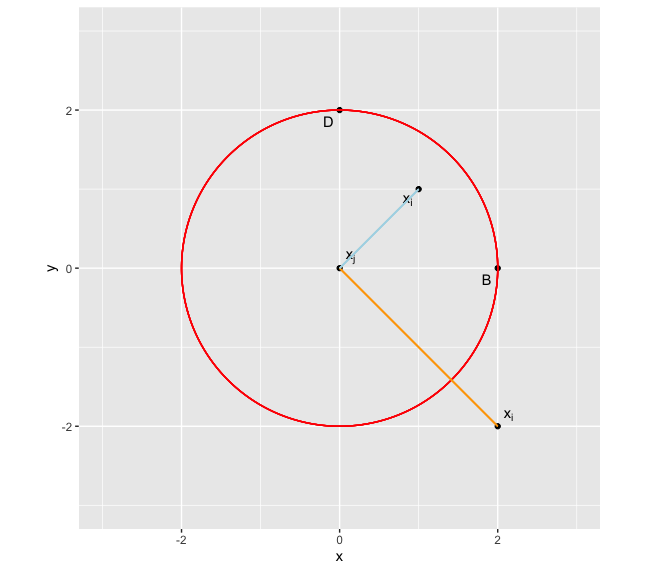{width="60%"}

-   Local reachability density: It is inverse of the average reachability distance of a point A from its neighbors. The exact formula is:

    $LRD_k(A)=\frac{1}{\sum_{x_j\in N_k(A)} \frac{RD(A,x_j)}{||N_k(A)||}}$

    Intuitively according to the LRD formula, the higher the average reachability distance (i.e., neighbors are far from the point), the smaller the density of points are present around a particular point. This tells us how far a point is from the nearest cluster of points. Low LRD value imply that the closest cluster is far from the point.

    In other words, the LRD relies on the intuition that the longer the distance to the next neighbors, the sparser the area the respective point is located in. It tells us how far we have to travel from our point to reach the next point or cluster of points. So the lower it is, the less dense it is, the longer we have to travel.

-   The LRD of each point is compared with the average LRD of its K-neighbors. We compute the local outlier factor or LOF which is the ratio of between the average LRD of the K-neighbors of point A and the LRD of A.

Or more specifically: $LOF_k(A)=\frac{\sum_{x_j\in N_k(A)} LRD_k(x_j)}{||N_k(A)||}\times\frac{1}{LRD_k(A)}$

-   Intuitively, if the point is not an outlier (i.e is an inlier), the ratio of average LRD of neighbors is approximately equal to the LRD of the point (because the density of a point and its neighbors are roughly equal). In that case, LOF is nearly equal to 1. On the other hand, if the point is an outlier, the LRD of a point is less than the average LRD of neighbors. Then LOF value will be high.

-   Generally, if LOF\> 1, the point is considered an outlier, but that is not always true. Let’s say we know that we only have one outlier in the data, then we take the maximum LOF value among all the LOF values, and the point corresponding to the maximum LOF value will be considered as an outlier.

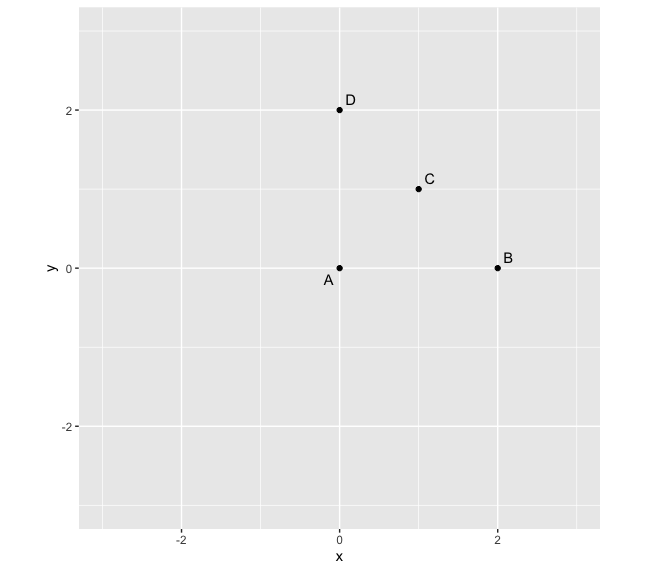{width="65%"}

-   4 points: A(0,0), B(1,0), C(1,1) and D(0,3) and K=2.
-   We will use LOF to detect one outlier (D) among these 4 points.
-   First, calculate the K-distance, distance between each pair of points, and K-neighborhood of all the points with K=2
-   We will be using the Manhattan distance as a measure of distance i.e $d(x,y)=\sum_{i=1}^n |x_i-y_i|$

| Distance | Value |
|----------|-------|
| d(A,B)   | 1     |
| d(A,C)   | 2     |
| d(A,D)   | 3     |
| d(B,C)   | 1     |
| d(B,D)   | 4     |
| d(C,D)   | 3     |

K-distance(A): since C is the 2$^{nd}$ nearest neighbor of A, K-distance(A)=d(A,C) =2

K-distance(B): since A, C are the 2$^{nd}$ nearest neighbor of B, K-distance(B)=distance(B,C) OR K-distance(B)=distance(B,A) = 1

K-distance(C): since A is the 2$^{nd}$ nearest neighbor of C –\> K-distance(C)=distance(C,A) =2

K-distance(D): since A,C are the 2$^{nd}$ nearest neighbor of D –\> K-distance(D)=distance(D,A) or K-distance(D)=distance(D,C) =3

-   K-neighborhood (A) = {B,C} , $||N_2(A)|| =2$
-   K-neighborhood (B) = {A,C}, $||N_2(B)|| =2$
-   K-neighborhood (C)= {B,A}, $||N_2(C)|| =2$
-   K-neighborhood (D) = {A,C}, $||N_2(D)|| =2$

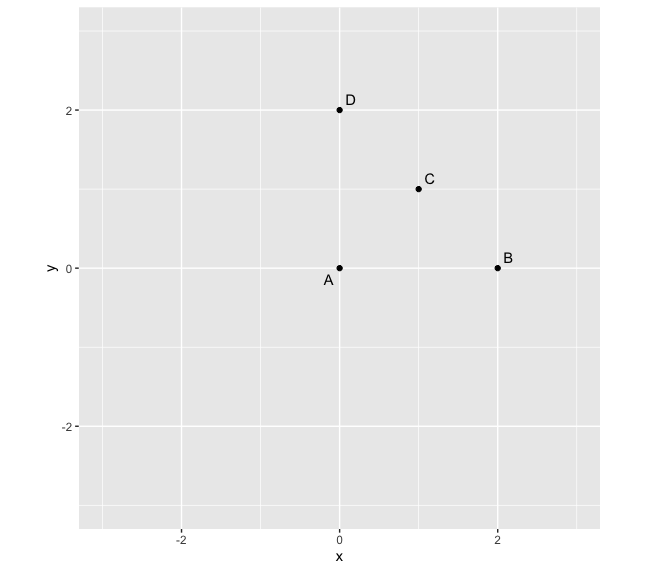{width="65%"}

We use the K-distance and K-neighbourhood to compute the LRD for each point

$LRD_2(A)=\frac{1}{\frac{RD(A,B)+RD(A,C)}{||N_2(A)||}}=\frac{\frac{1}{1+2}}{2}=0.667$ $LRD_2(B)=\frac{1}{\frac{RD(B,A)+RD(B,C)}{||N_2(B)||}}=\frac{\frac{1}{2+2}}{2}=0.50$ $LRD_2(C)=\frac{1}{\frac{RD(C,A)+RD(C,B)}{||N_2(C)||}}=\frac{\frac{1}{1+2}}{2}=0.667$ $LRD_2(D)=\frac{1}{\frac{RD(D,A)+RD(D,C)}{||N_2(D)||}}=\frac{\frac{1}{3+3}}{2}=0.337$

$LOF_2(A)=\frac{LRD_2(B)+LRD_2(C)}{||N_2(A)||}\times\frac{1}{LRD_2(A)}=\frac{0.5+0.667}{2}\times\frac{1}{0.667}=0.87$ $LOF_2(B)=\frac{LRD_2(A)+LRD_2(C)}{||N_2(B)||}\times\frac{1}{LRD_2(B)}=\frac{0.667+0.667}{2}\times\frac{1}{0.5}=1.334$ $LOF_2(C)=\frac{LRD_2(A)+LRD_2(B)}{||N_2(C)||}\times\frac{1}{LRD_2(C)}=\frac{0.667+0.5}{2}\times\frac{1}{0.667}=0.87$ $LOF_2(D)=\frac{LRD_2(A)+LRD_2(C)}{||N_2(D)||}\times\frac{1}{LRD_2(D)}=\frac{0.667+0.667}{2}\times\frac{1}{0.337}=2$

The highest LOF among the four points is LOF(D). Therefore, D is an outlier/anomaly.

If you want to try and understand the details of LOF better, you can have a look at [this video](https://www.youtube.com/watch?v=Ymvq6JHjoBY) or [this one](https://www.youtube.com/watch?v=CePgbdVdLvg) (more detailed).

### Local outlier factor (LOF): Pros and Cons

*Pros*

-   LOF identifies outliers based on the local neighborhood
-   A point will be considered as an anomaly/outlier if it is at a short distance from an extremely dense cluster.
-   A global approach may not consider that point as an outlier. But LOF can effectively identify local outliers. It gives better results than the global approach to find outliers

*Cons*

-   Since LOF is a ratio, it is difficult to interpret
-   There is no threshold value to LOF and the selection of a point as an anomaly/outlier is user-dependent (and also problem-dependent)

Let's work with reduced 2 features Better Life Index dataset:

In [32]:
seed = 665544
np.random.seed(seed)
random.seed(seed)

### calculate LOF score with a neighborhood of 5 points
lof_model = LocalOutlierFactor(n_neighbors=5, contamination="auto")
lof_scores = -lof_model.fit_predict(df_final_scaled[['Labour market insecurity (Percentage)','Life satisfaction (Average score)']]) # we compute the LOF score with a number of neighbours of 5 (the same number that we chose for DBSCAN clustering!) and just as with Isolation Forest, we negate the prediction to get an anomaly score not a probability!

# Step 2: Add LOF scores to DataFrame
df_final_scaled["lof_score"] = -lof_model.negative_outlier_factor_

Let's check our distribution of Local Outlier Factors!

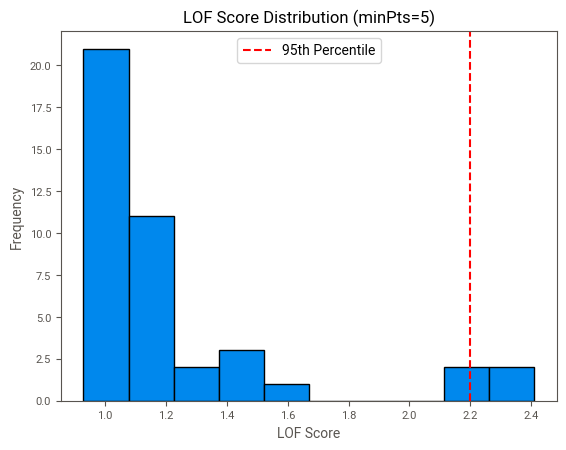

In [33]:
### distribution of outlier factors
plt.hist(df_final_scaled["lof_score"], bins=10, edgecolor="black")
plt.axvline(np.percentile(df_final_scaled["lof_score"], 95), color="red", linestyle="dashed", label="95th Percentile")
plt.xlabel("LOF Score")
plt.ylabel("Frequency")
plt.title("LOF Score Distribution (minPts=5)")
plt.legend()
plt.show()

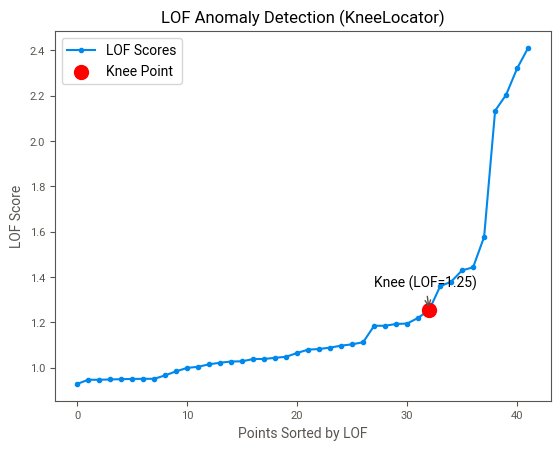

In [34]:
# Sort LOF scores
sorted_lof_scores = np.sort(df_final_scaled["lof_score"].values)

# Try different curve & direction settings
knee_locator = KneeLocator(
    x=np.arange(len(sorted_lof_scores)), 
    y=sorted_lof_scores, 
    curve="convex",  # Try "convex" instead of "concave"
    direction="increasing",  # LOF scores increase for anomalies
    S=2  # Sensitivity parameter (higher values smooth the curve)
)

# Ensure KneeLocator found a valid knee
if knee_locator.knee is not None:
    lof_threshold = sorted_lof_scores[knee_locator.knee]

    # Plot LOF scores
    plt.plot(sorted_lof_scores, marker="o", linestyle="-", label="LOF Scores")

    # Mark knee point
    plt.scatter(knee_locator.knee, lof_threshold, color="red", s=100, zorder=3, label="Knee Point")
    plt.annotate(f"Knee (LOF={lof_threshold:.2f})", 
                 xy=(knee_locator.knee, lof_threshold), 
                 xytext=(knee_locator.knee - 5, lof_threshold + 0.1),
                 arrowprops=dict(facecolor="red", arrowstyle="->"), fontsize=10)

    # Labels and title
    plt.xlabel("Points Sorted by LOF")
    plt.ylabel("LOF Score")
    plt.title("LOF Anomaly Detection (KneeLocator)")
    plt.legend()
    plt.show()
else:
    print("KneeLocator did not find a clear knee. Try adjusting the parameters or using an alternative method.")

It looks like points are anomalous starting from a LOF score of 1.25...

And finally...

In [35]:
ggplot(df_final_scaled, aes(x='Labour market insecurity (Percentage)',y='Life satisfaction (Average score)', color="lof_score", size="lof_score")) + \
    geom_point(alpha=0.5,tooltips=layer_tooltips()
            .line("Country: @Country")) + \
    scale_color_viridis(option="viridis", direction=1) + \
    scale_size(range=[1, 10]) + \
    theme_minimal() + \
    labs(title="Scatter Plot with LOF Scores (Viridis)",
         x='Labour market insecurity (Percentage)',
         y='Life satisfaction (Average score)',
         color="LOF Score",
         size="LOF Score")

For more details on LOF, see Breunig, Markus M., Hans-Peter Kriegel, Raymond T. Ng, and Jörg Sander. "LOF: identifying density-based local outliers." In Proceedings of the 2000 ACM SIGMOD international conference on Management of data, pp. 93-104. 2000.

🏡 **TAKE-HOME EXERCISE**: Can you apply LOF on the full Better Life Index indicators dataset?

For a more involved example of how to apply LOF (with PCA included!) in a fraud detection context, see [here](https://rpubs.com/muh_risman/LOF)